Notebook exploring how errors in positions + armlengths couple into the GW response.

# Import needed packages

Everything except segwo is on pypi, and can simply be installed with pip. SEGWO should be published to pypi soon, but for now has to be grabbed from gitlab, https://gitlab.com/j2b.bayle/segwo

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from lisaorbits import StaticConstellation
from lisaconstants import c
import segwo
np.random.seed(42)

# Preliminary: compute response for static constellation

In [49]:
# Define a frequency axis
f = np.logspace(-4, np.log10(2e-2), 500)

# Define static combination with equal arms
orbits = StaticConstellation.from_armlengths(2.5e9, 2.5e9, 2.5e9)

# Compute the positions of the spacecraft and the light travel times at t=0.0
ltts = orbits.compute_ltt(t=[0.0])
positions = orbits.compute_position(t=[0.0])

In [50]:
# Compute the signal covariance matrix for eta variables

# We use healpy to define a grid of points on the sky
nside = 12

npix = hp.nside2npix(nside)
thetas, phis = hp.pix2ang(nside, np.arange(npix))
# Conversion from colatitude to latitude
betas, lambs = np.pi / 2 - thetas, phis

# This computes the complex signal response for the given frequencies and sky locations
strain2link = segwo.response.compute_strain2link(
            f, betas, lambs, ltts, positions
        )

In [51]:
# Shape: times, frequencies, pixels, links, polarizations
# Ie., it's the mixing matrix to go from h+/hx in terms of strain to single link
# response in terms of fractional frequency deviation. See segwo documentation for details.
strain2link.shape

(1, 500, 1728, 6, 2)

In [52]:
# np.max(np.abs(segwo.response.compute_strain2link(
#             f, beta_zero, lamb_zero, ltts, positions
#         )[0,:,:,0,1]), axis=0).shape

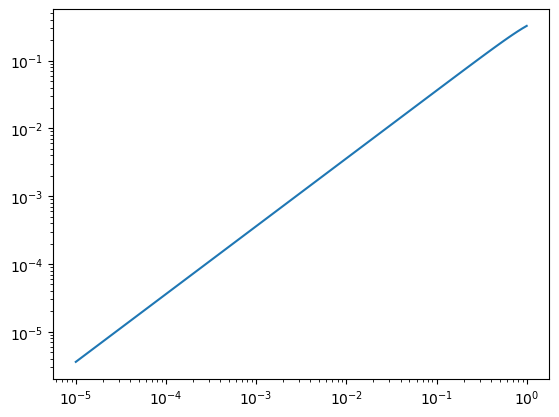

In [53]:
# Compute some points smoothly approaching a zero of hx (ie., the whole xy plane)
beta_zero = np.logspace(-5, 0, 100)
lamb_zero = beta_zero**0
plt.loglog(beta_zero, np.max(np.abs(segwo.response.compute_strain2link(
            f, beta_zero, lamb_zero, ltts, positions
        )[0,:,:,0,1]), axis=0))

strain2link_zero_approach = segwo.response.compute_strain2link(
            f, beta_zero, lamb_zero, ltts, positions
        )

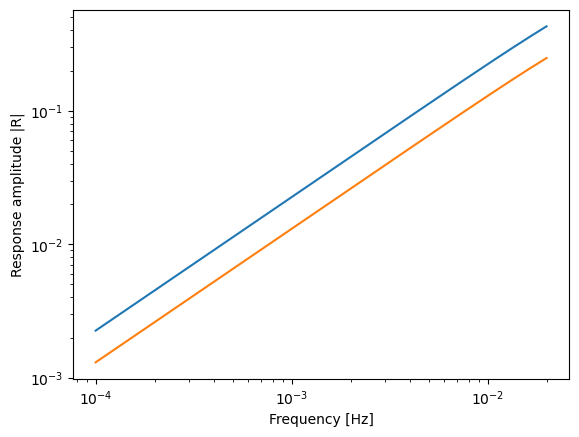

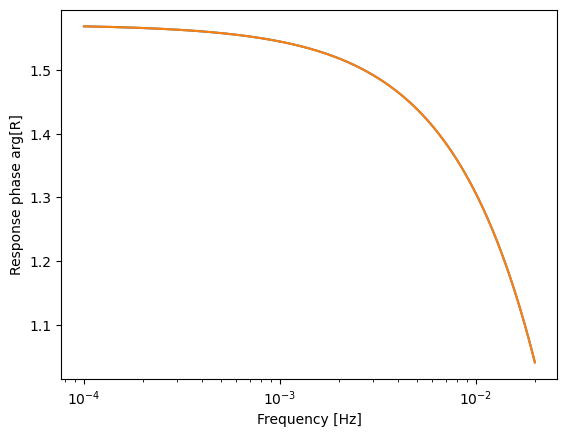

In [54]:
# Show response for one of the pixels for both polarizations
plt.loglog(f, np.abs(strain2link[0, :, 0, 0, :]))
plt.xlabel("Frequency [Hz]")
plt.ylabel("Response amplitude |R|")
plt.show()

plt.figure()
plt.semilogx(f, np.angle(strain2link[0, :, 0, 0, :]))
plt.xlabel("Frequency [Hz]")
plt.ylabel("Response phase arg[R]")
plt.show()

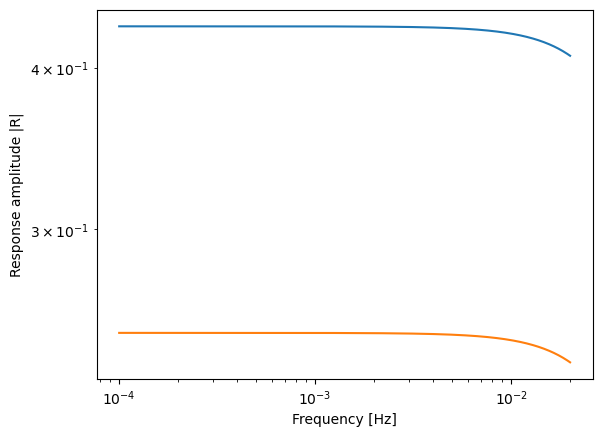

In [55]:
# Convert from fractional frequency shift to strain.
# We integrate to get timing; we multiply by c to get meters; we divide by L to get strain.
L = 2.5e9
ffd2strain = 1/(2 * np.pi * f) * c / L

# Show response for one of the pixels for both polarizations
plt.loglog(f, np.abs(strain2link[0, :, 0, 0, :]) * ffd2strain[:, np.newaxis])
plt.xlabel("Frequency [Hz]")
plt.ylabel("Response amplitude |R|")
plt.show()

Plot sky map of response. We have to fix frequency, link and polarization.

Not sure how to best visualize this over all frequencies...

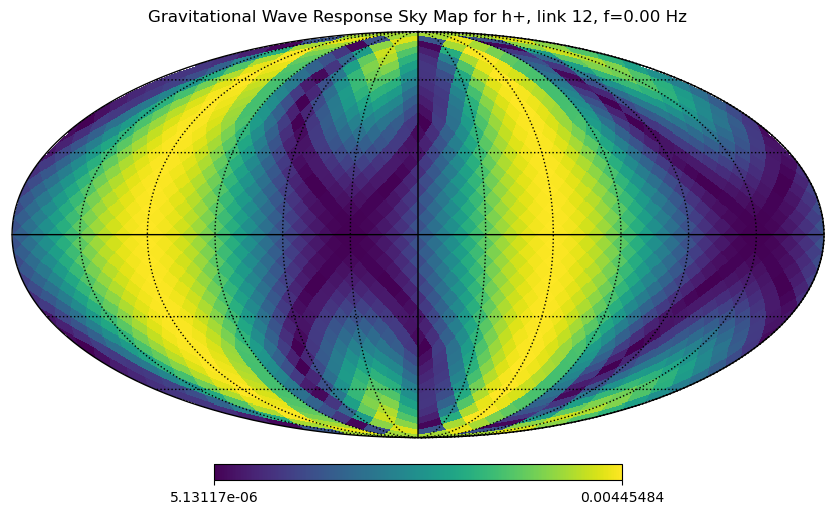

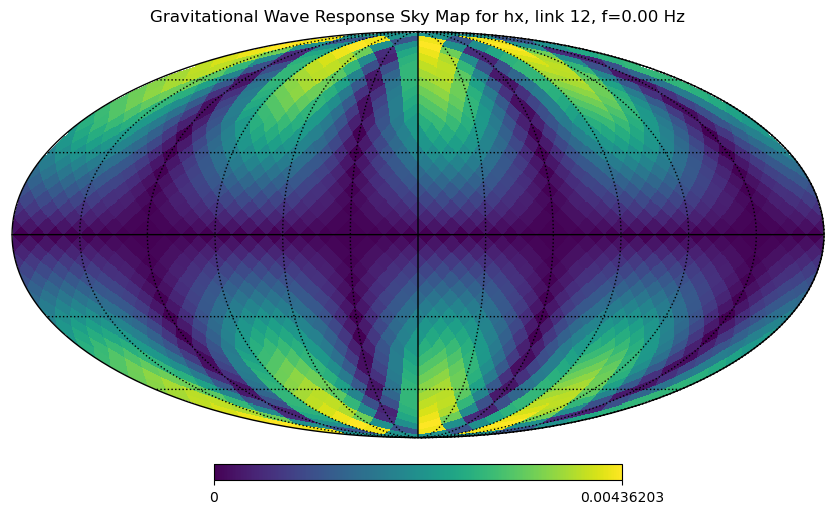

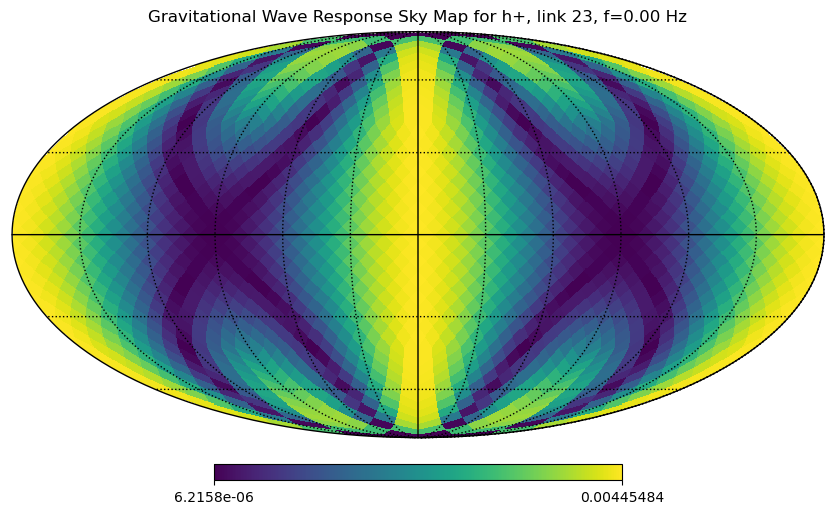

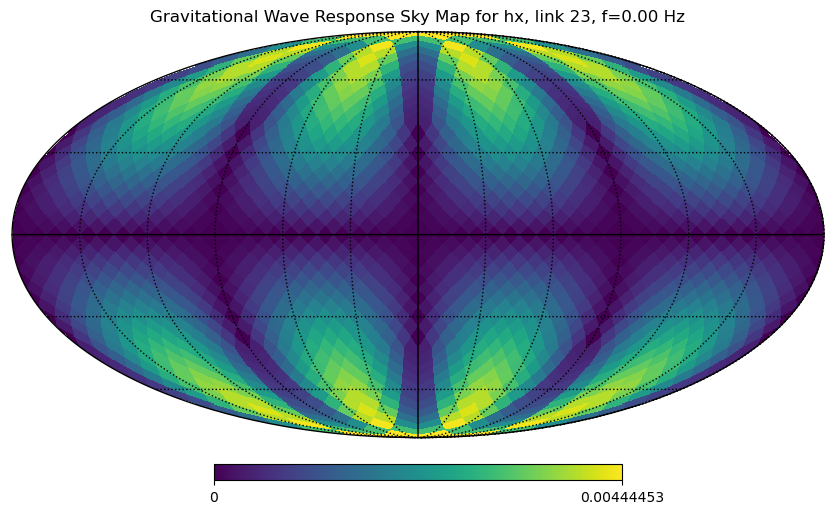

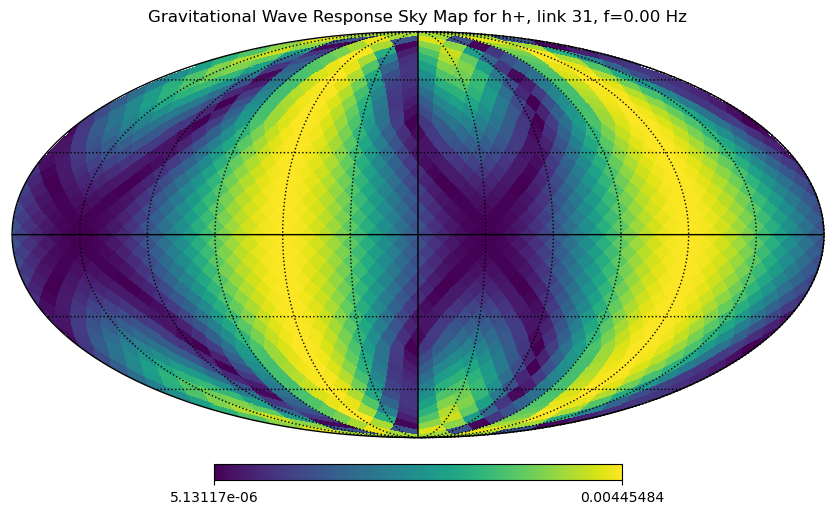

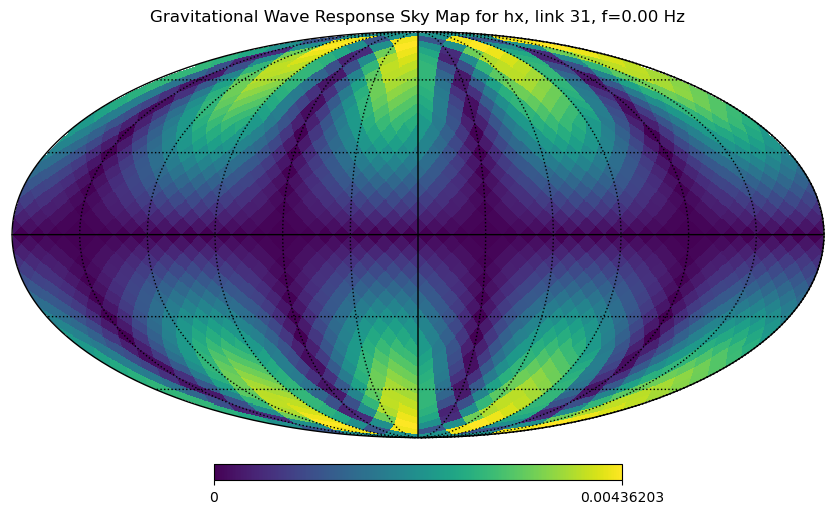

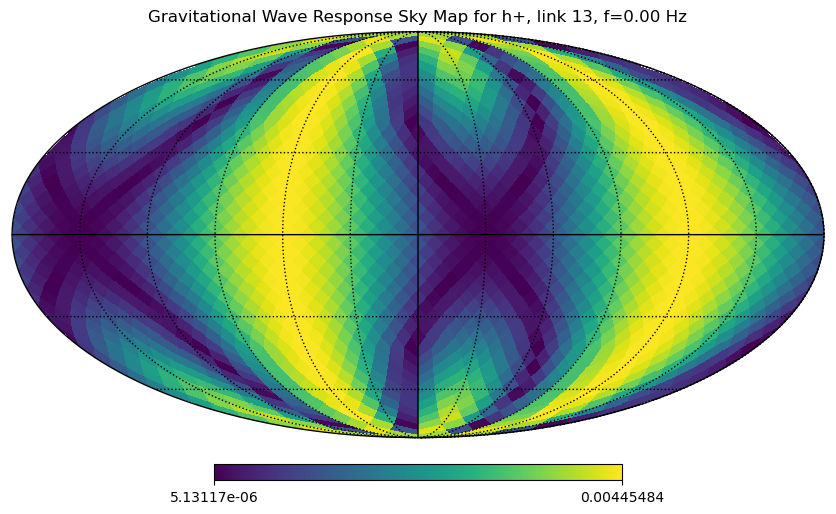

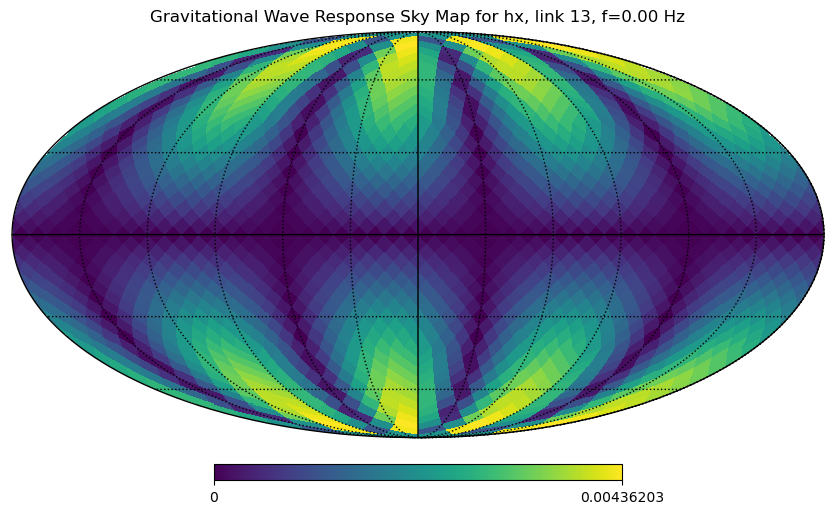

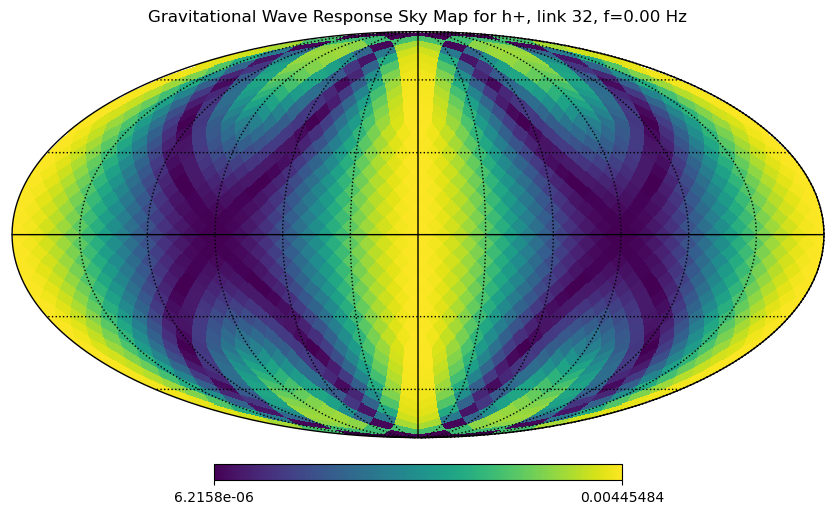

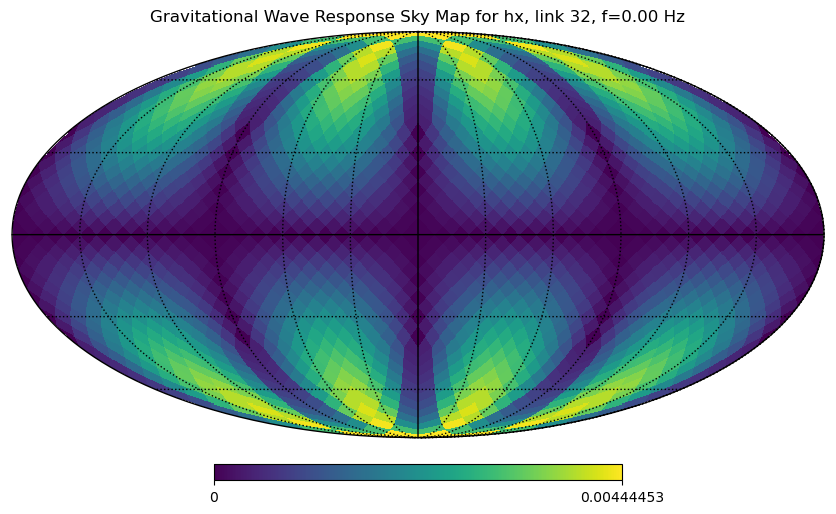

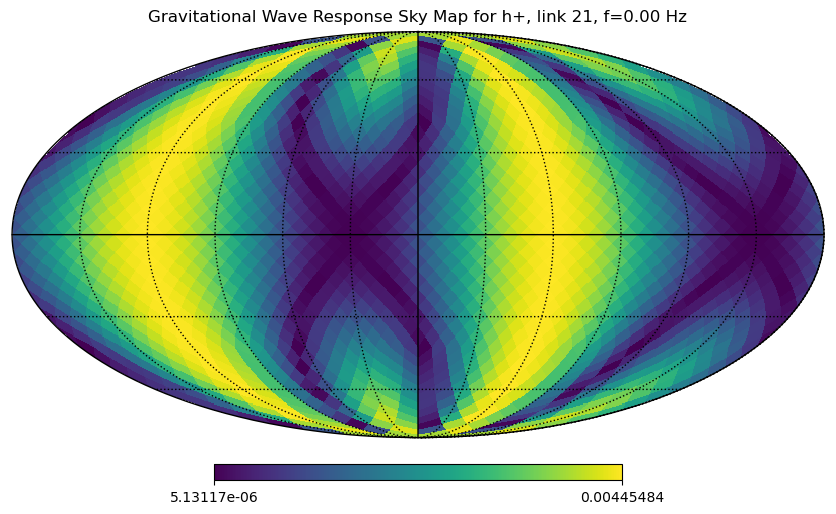

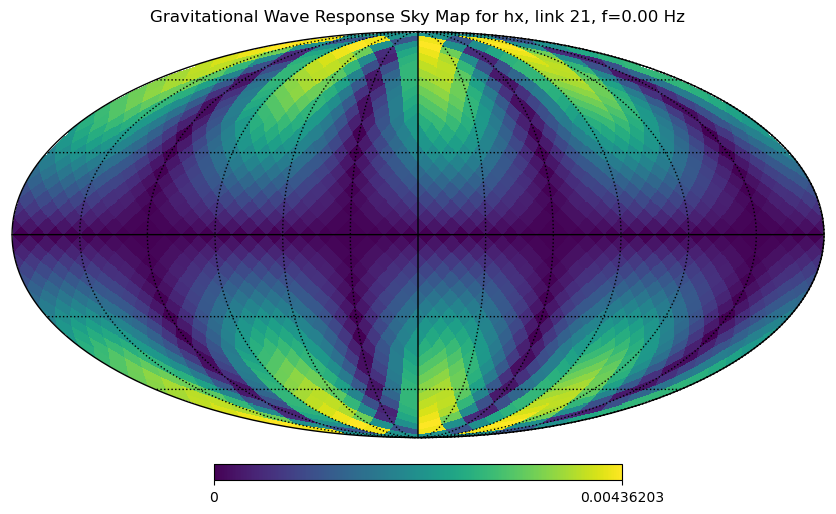

In [56]:
# Placeholder for GW response map (this will be filled with your actual data)
gw_response_map = np.zeros(npix)


f_eval = 50 # frequency bin at which to evaluate the response
# pol = 0 # which polarization to use
pols = ['h+', 'hx']

for link in range(6):
    # link = 0 # which link to plot
    for pol in range(2):

        # Populate the map with the GW response for each pixel
        for pix in range(npix):
            # Compute the frequency-dependent GW response (replace with actual response)
            gw_response_map[pix] = np.abs(strain2link[0, f_eval, pix, link, pol])

        # Plotting the map
        hp.mollview(gw_response_map, title=f"Gravitational Wave Response Sky Map for {pols[pol]}, link {orbits.LINKS[link]}, f={f[f_eval]:.2f} Hz", rot=[0, 0])
        hp.graticule()
        plt.show()

To get a more familiar picture, look at response of TDI XYZ instead

In [57]:
from pytdi.michelson import X2_ETA, Y2_ETA, Z2_ETA

In [58]:
A = (Z2_ETA - X2_ETA) / np.sqrt(2)
E = (X2_ETA - 2 * Y2_ETA + Z2_ETA) / np.sqrt(6)
T = (X2_ETA + Y2_ETA + Z2_ETA) / np.sqrt(3)

In [59]:
# Let's look at the projection on TDI
eta_list = [f"eta_{mosa}" for mosa in orbits.LINKS]
link2x = segwo.cov.construct_mixing_from_pytdi(f, eta_list, [A, E, T], ltts)
# We need to manually fill in the array for each pixel
link2x = link2x[:,:,np.newaxis,:,:]

# We can then compose the mixing matrices to go directly from strain to TDI variables
strain2x = segwo.cov.compose_mixings([strain2link, link2x])


In [60]:
# link2x is the mixing matrix to go from 6 single links to 3 TDI variables
print(strain2link.shape, link2x.shape)

(1, 500, 1728, 6, 2) (1, 500, 1, 3, 6)


In [61]:
strain2x_zero_approach = segwo.cov.compose_mixings([strain2link_zero_approach, link2x])

In [62]:
strain2link.shape

(1, 500, 1728, 6, 2)

In [63]:
strain2link_zero_approach.shape

(1, 500, 100, 6, 2)

In [64]:
strain2x_zero_approach.shape

(1, 500, 100, 3, 2)

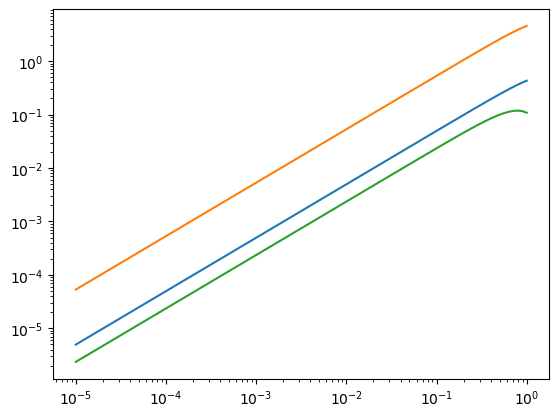

In [65]:
for tdi_channel in range(3):
    plt.loglog(beta_zero, np.max(np.abs(strain2x_zero_approach)[0,:,:,tdi_channel,1], axis=0), label=f'hx, TDI channel {'AET'[tdi_channel]}')

In [66]:
# This now goes from 2 strain polarizations to 3 TDI variables
# Shape: times, frequencies, pixels, tdi variables, polarizations
strain2x.shape

(1, 500, 1728, 3, 2)

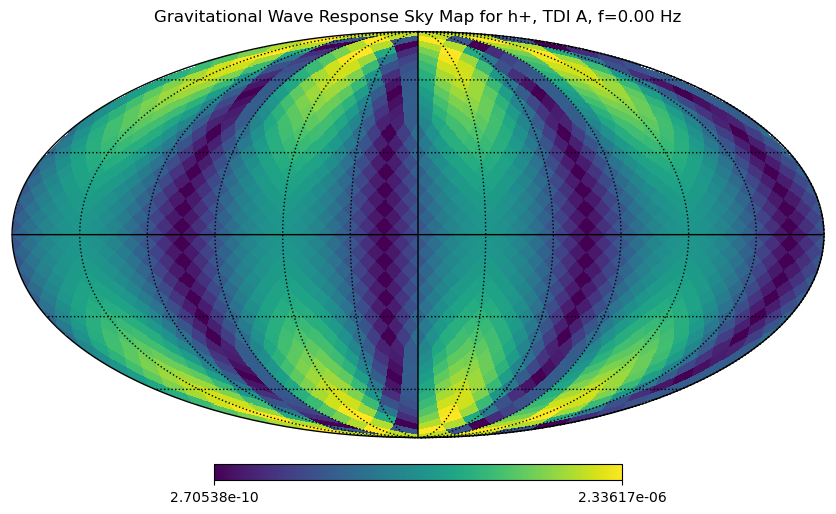

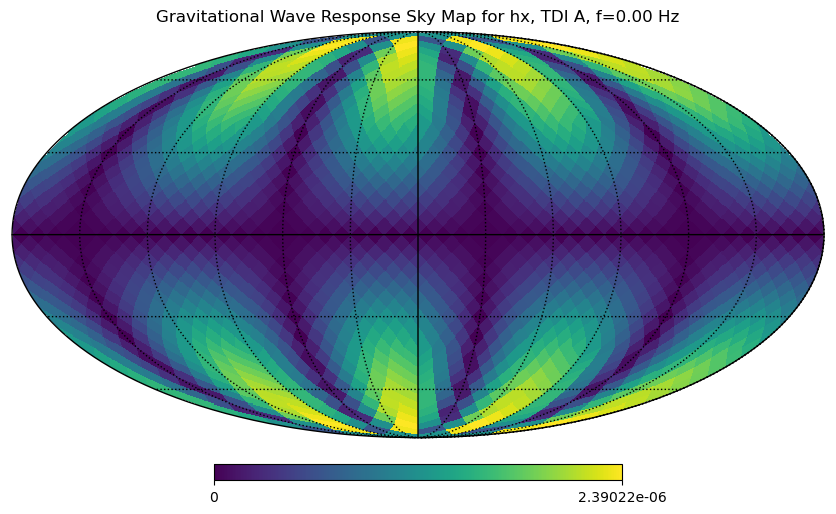

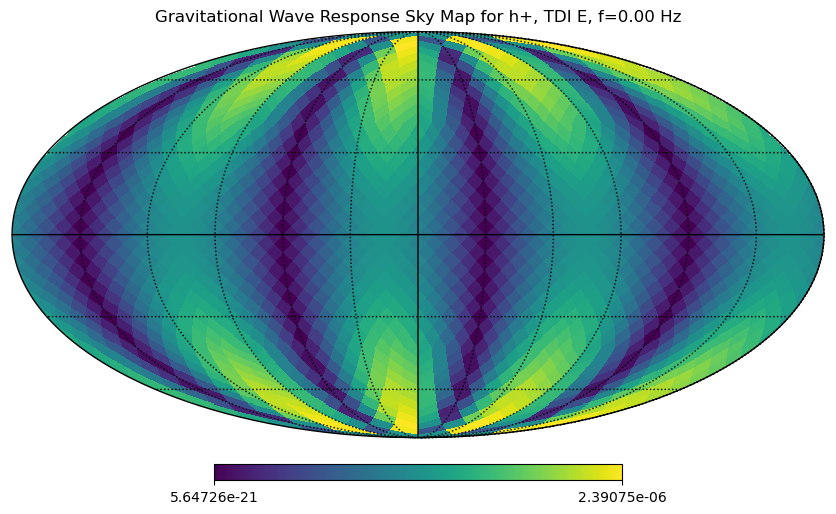

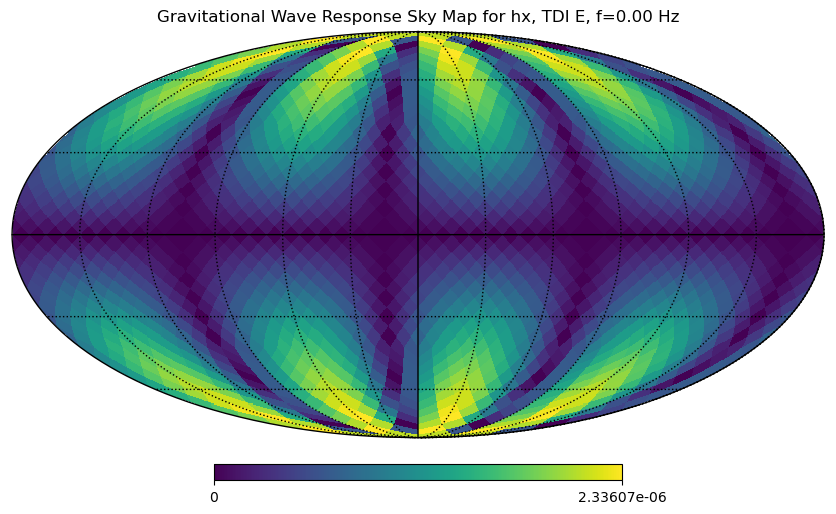

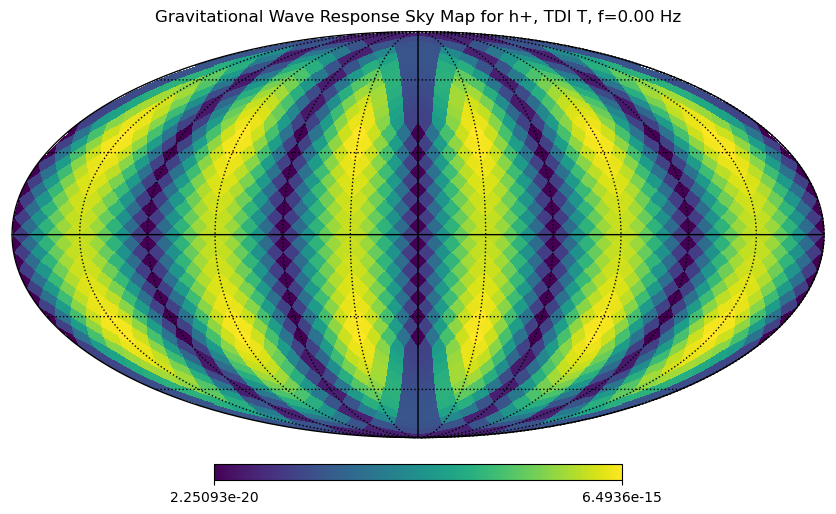

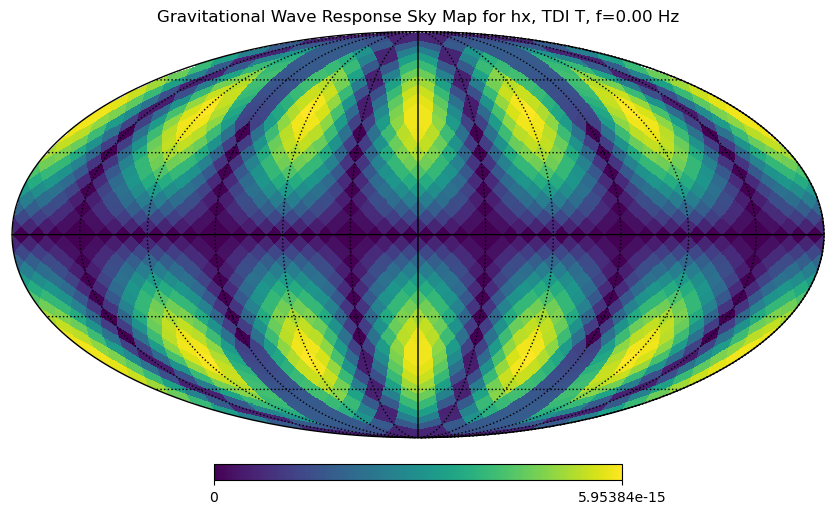

In [67]:
# Placeholder for GW response map (this will be filled with your actual data)
gw_response_map = np.zeros(npix)


f_eval = 0 # frequency bin at which to evaluate the response
pol = 0 # which polarization to use

# Plot response for all three channels
for channel in range(3):
    for pol in range(2):
        # Populate the map with the GW response for each pixel
        for pix in range(npix):
            # Compute the frequency-dependent GW response (replace with actual response)
            gw_response_map[pix] = np.abs(strain2x[0, f_eval, pix, channel, pol])

        # Plotting the map
        hp.mollview(gw_response_map, 
                    title=f"Gravitational Wave Response Sky Map for {pols[pol]}, TDI {'AET'[channel]}, f={f[f_eval]:.2f} Hz", rot=[0, 0])
        hp.graticule()
        plt.show()

    


# Add noise

To check how errors propagate, we could generate a few random realizations and see
how the response changes.

Getting the error in the positions right is not entirely trivial; we have very good 
knowledge of the armlength (technically the light travel time, but maybe for now assume 
static constellation without relativity to inject the error) but large errors on 
absolute positions.

Proposed model:
 - generate sc positions from slightly perturbed armlengths
 - apply rotation + translation to perturbed triangle to simulate absolute error

This ensures we don't perturb the armlength by the large absolute errors.

As the armlength errors are very small, we'd expect their impact to be a lot less strong
than the other two effects. In addition, translations should not really affect the
amplitude of the response, but correspond to a small phase error?

Note that we expect large relative error for directions + frequencies where the response
is nominally vanishing.

In [68]:
def perturbed_static_orbits(arm_lengths, armlength_error, rotation_error, translation_error, rot_fac = 2.127):
    """ Apply perturbations to the static orbits 
    
    We want to create a situation where the armlengths are known very well, but the
    absolute positions of the spacecraft are not known very well.

    This is achieved by applying a small perturbation to the armlengths
    followed by a rotation and translation to the spacecraft 
    positions (around random axis and directions).
    
    Parameters
    ----------
    arm_lengths : np.array
        Nominal armlengths of the constellation.
    armlength_error : float
        Standard deviation of the perturbation to apply to the armlengths, in meters.
    rotation_error : float
        Standard deviation of the rotation to apply to the spacecraft positions, in equivalent meters of displacement.
    translation_error : float
        Standard deviation of the translation to apply to the spacecraft positions, in meters.

    """
    # Create new orbits with perturbed armlengths
    perturbed_ltt_orbits = StaticConstellation.from_armlengths(arm_lengths[0] + np.random.normal(0, armlength_error), 
                                                       arm_lengths[1] + np.random.normal(0, armlength_error), 
                                                       arm_lengths[2] + np.random.normal(0, armlength_error))
    
    # Apply rotation by an angle phi along a random axis in 3d space

    # Generate a random rotation matrix
    # Random axis of rotation
    axis = np.random.randn(3)
    axis /= np.linalg.norm(axis)  # Normalize the axis

    # Average distance of the spacecraft from the center of mass
    avg_distance = np.mean(np.linalg.norm(perturbed_ltt_orbits.sc_positions, axis=1))

    # In the small angle approximation, the rotation by an angle phi causes a displacement
    # of the spacecraft positions by a distance d = r * phi. Solving for phi and using d = error_magnitude gives
    # phi = d / r
    # TODO: improve on the math here; not all rotations affect all S/C, so this is
    # off by a factor of 2 or so; for now just fitted by hand
    angle = rot_fac * rotation_error / avg_distance

    # Rotation matrix using Rodrigues' rotation formula
    K = np.array([[0, -axis[2], axis[1]],
                [axis[2], 0, -axis[0]],
                [-axis[1], axis[0], 0]])
    R = np.eye(3) + np.sin(angle) * K + (1 - np.cos(angle)) * np.outer(axis, axis)

    # Apply the rotation to the spacecraft positions
    rotated_positions = np.dot(R, perturbed_ltt_orbits.sc_positions.T).T

    # Apply translation to the spacecraft positions
    translation = np.random.normal(0, translation_error, size=(3,))
    perturbed_positions = rotated_positions + translation
    
    # Create a new StaticConstellation object with the perturbed positions
    perturbed_orbits = StaticConstellation(perturbed_positions[0], perturbed_positions[1], perturbed_positions[2])
    return perturbed_orbits

## Some testing

In [69]:
# check we get the correct error statistics
# Only armlengths + rotation error
N = 1000
ltt_residuals = np.zeros((N, 6))
position_residuals = np.zeros((N, 3, 3))

for i in range(N):
    porbit = perturbed_static_orbits(
        arm_lengths=[2.5e9, 2.5e9, 2.5e9], 
        armlength_error=1, 
        rotation_error=50e3, 
        translation_error=0
    )

    cperturbed_ltts = porbit.compute_ltt(t=[0.0])
    cperturbed_positions = porbit.compute_position(t=[0.0])

    ltt_residuals[i, :] = cperturbed_ltts - ltts
    position_residuals[i, :] = cperturbed_positions - positions


In [70]:
for i in range(6):
    print(f"ltt std for link {orbits.LINKS[i]}", np.std(ltt_residuals[:, i])*c, "meters")

ltt std for link 12 0.9810883919757584 meters
ltt std for link 23 1.0099673016681656 meters
ltt std for link 31 1.0242691199895086 meters
ltt std for link 13 1.0242691199895086 meters
ltt std for link 32 1.0099673016681656 meters
ltt std for link 21 0.9810883919757584 meters


In [71]:
for i in range(3):
    print(f"Position std for sc {i}:", np.std(position_residuals[:,i]), "meters")

Position std for sc 0: 49953.67020333106 meters
Position std for sc 1: 50100.47474067069 meters
Position std for sc 2: 50901.86883944257 meters


In [72]:
# Values above where used to fit the rotation error factor, should be computed from geometry

In [73]:
# check we get the correct error statistics
# Only armlengths + translation error
N = 1000
ltt_residuals = np.zeros((N, 6))
position_residuals = np.zeros((N, 3, 3))

for i in range(N):
    porbit = perturbed_static_orbits(
        arm_lengths=[2.5e9, 2.5e9, 2.5e9], 
        armlength_error=1, 
        rotation_error=0, 
        translation_error=50e3
    )

    cperturbed_ltts = porbit.compute_ltt(t=[0.0])
    cperturbed_positions = porbit.compute_position(t=[0.0])

    ltt_residuals[i, :] = cperturbed_ltts - ltts
    position_residuals[i, :] = cperturbed_positions - positions

In [74]:
for i in range(6):
    print(f"ltt std for link {orbits.LINKS[i]}", np.std(ltt_residuals[:, i])*c, "meters")

ltt std for link 12 1.0055004889019727 meters
ltt std for link 23 1.0356517922140054 meters
ltt std for link 31 1.0008177937059493 meters
ltt std for link 13 1.0008177937059493 meters
ltt std for link 32 1.0356517922140054 meters
ltt std for link 21 1.0055004889019727 meters


In [75]:
for i in range(3):
    print(f"Position std for sc {i}:", np.std(position_residuals[:,i]), "meters")

Position std for sc 0: 50400.71359006383 meters
Position std for sc 1: 50400.69308072352 meters
Position std for sc 2: 50400.71573868294 meters


In [76]:
# Now put it together, both rotation and translation error, with the scaling applied

# check we get the correct error statistics
# Only armlengths + rotation error
N = 1000
ltt_residuals = np.zeros((N, 6))
position_residuals = np.zeros((N, 3, 3))

for i in range(N):
    porbit = perturbed_static_orbits(
        arm_lengths=[2.5e9, 2.5e9, 2.5e9], 
        armlength_error=1, 
        rotation_error=50e3, 
        translation_error=50e3
    )

    cperturbed_ltts = porbit.compute_ltt(t=[0.0])
    cperturbed_positions = porbit.compute_position(t=[0.0])

    ltt_residuals[i, :] = cperturbed_ltts - ltts
    position_residuals[i, :] = cperturbed_positions - positions

In [77]:
for i in range(6):
    print(f"ltt std for link {orbits.LINKS[i]}", np.std(ltt_residuals[:, i])*c, "meters")

ltt std for link 12 1.0071336717767272 meters
ltt std for link 23 1.0327728919507833 meters
ltt std for link 31 1.0503456924841965 meters
ltt std for link 13 1.0503456924841965 meters
ltt std for link 32 1.0327728919507833 meters
ltt std for link 21 1.0071336717767272 meters


In [78]:
for i in range(3):
    print(f"Position std for sc {i}:", np.std(position_residuals[:,i]), "meters")

Position std for sc 0: 68933.94479518155 meters
Position std for sc 1: 70338.94341891167 meters
Position std for sc 2: 70445.99283836987 meters


In [79]:
# Check the translation + rotation add up as uncorrelated errors
50e3 * np.sqrt(2)

np.float64(70710.67811865476)

# Check influence of uncertainties on response

This is pretty preliminary; just trying to get an idea of the average error we get
in the response for a given set of input noises. Needs a bit more thinking.

For reference, these are the requirements we start from:

```
SCI-MIS-0250: Knowledge of the antenna pattern in amplitude

The susceptibility of the observatory to the strain of a GW shall be known to better than 10−4 in amplitude for any polarisation of the GW, at any given time during the mission lifetime, and for any given position of the GW source in the sky.

SCI-MIS-0260: Knowledge of the antenna pattern in phase

The susceptibility of the observatory to the strain of a GW shall be known to better than 10−2 rad in phase for any polarisation of the GW, at any given time during the mission lifetime, and for any given position of the GW source in the sky. 

Rationale: Many science objectives and science investigations depend on the knowledge of the strain of the gravitational wave signal that needs to be calculated from the measured signal with sufficient accuracy. Requiring the which is given by this requirement. In the flow-down, this sets requirements on spacecraft (S/C) position knowledge, knowledge of the laser wavelength, precision of the reconstruction etc. 
```


## rotations

In [80]:
# Generate some realizations so we can do statistics
N = 100
perturbed_ltt = np.zeros((N, 6))
perturbed_positions = np.zeros((N, 3, 3))

for i in range(N):
    perturbed_orbit = perturbed_static_orbits(
        arm_lengths=[2.5e9, 2.5e9, 2.5e9], 
        armlength_error=0, 
        rotation_error=5e3, 
        translation_error=0
    )

    perturbed_ltt[i] = perturbed_orbit.compute_ltt(t=[0.0])
    perturbed_positions[i] = perturbed_orbit.compute_position(t=[0.0])

In [81]:
# Compute the signal covariance matrix for eta variables

# We use healpy to define a grid of points on the sky
nside = 12
npix = hp.nside2npix(nside)
thetas, phis = hp.pix2ang(nside, np.arange(npix))
# Conversion from colatitude to latitude
betas, lambs = np.pi / 2 - thetas, phis

# this uses a bit of memory, and takes a moment; around 30s and 30GB on my machine
strain2links_perturbed = segwo.response.compute_strain2link(
                f, betas, lambs, perturbed_ltt, perturbed_positions # we're hi-jacking the time argument of segwo here for our realizations
            )

link2x_perturbed = segwo.cov.construct_mixing_from_pytdi(f, eta_list, [A, E, T], ltts)

# We need to manually fill in the array for each pixel
link2x_perturbed = link2x_perturbed[:,:,np.newaxis,:,:]

# We can then compose the mixing matrices to go directly from strain to TDI variables
strain2x_perturbed = segwo.cov.compose_mixings([strain2links_perturbed, link2x_perturbed])

KeyboardInterrupt: 

In [39]:
# this uses a bit of memory, and takes a moment; around 30s and 30GB on my machine
strain2links_zero_approach_perturbed = segwo.response.compute_strain2link(
                f, beta_zero, lamb_zero, perturbed_ltt, perturbed_positions # we're hi-jacking the time argument of segwo here for our realizations
            )

link2x_zero_approach_perturbed = segwo.cov.construct_mixing_from_pytdi(f, eta_list, [A, E, T], ltts)

# We need to manually fill in the array for each pixel
link2x_zero_approach_perturbed = link2x_zero_approach_perturbed[:,:,np.newaxis,:,:]

# We can then compose the mixing matrices to go directly from strain to TDI variables
strain2x_zero_approach_perturbed = segwo.cov.compose_mixings([strain2links_zero_approach_perturbed, link2x_zero_approach_perturbed])

In [40]:
strain2x_perturbed.shape

(100, 500, 1728, 3, 2)

In [41]:
# def relative_errors_sky(a, b):
#     """ Compute the relative errors between two arrays
#     """
#     return np.abs(a - b) / np.abs(b)

# use this one for normalizing errors wrt. the maximum amplitude
# def relative_errors_sky(a, b):
#     """ Compute the relative errors between two arrays, 
#         wrt. the direction of maximum amplitude
#     """
#     return np.abs(a - b) / np.max(np.abs(b), axis=2)[:, :, np.newaxis, :, :]

# use this one for normalizing errors wrt. the maximum amplitude
def relative_errors_sky(a, b):
    """ Compute the relative errors between two arrays, 
        wrt. the direction of maximum amplitude
    """
    return np.abs(a - b) / np.average(np.abs(b), axis=2)[:, :, np.newaxis, :, :]

In [42]:
def absolute_errors(a, b):
    """ Compute the relative errors between two arrays
    """
    return np.abs(a - b)

In [41]:
# Compute std for amplitude of perturbed response
strain2x_abs_error = np.std(relative_errors_sky(np.abs(strain2x_perturbed), np.abs(strain2x)), axis=0)

In [42]:
# Compute std for amplitude of perturbed response
strain2x_zero_approach_abs_error = np.std(relative_errors_sky(np.abs(strain2x_zero_approach_perturbed), np.abs(strain2x_zero_approach)), axis=0)

In [43]:
strain2x_zero_approach_abs_error.shape

(500, 100, 3, 2)

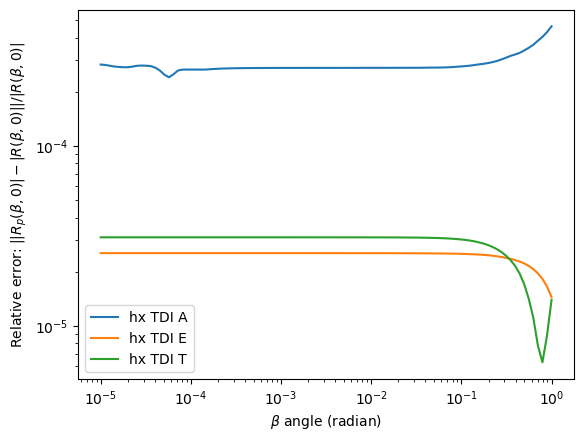

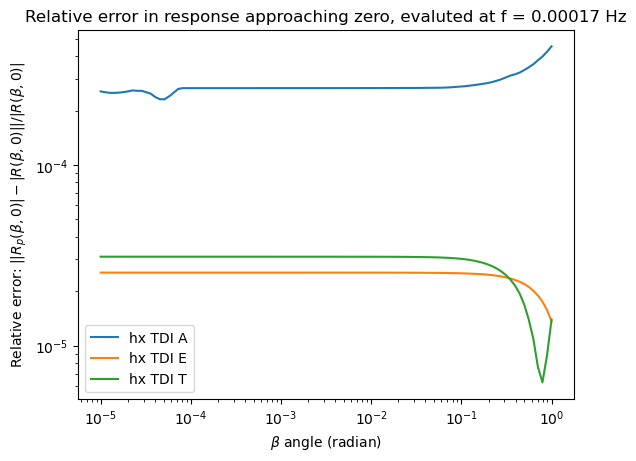

In [44]:
tdi_index = 0
pol_index = 1
f_index = 50

plt.figure()
for tdi_index in range(3):
    plt.loglog(beta_zero, np.max(np.abs(strain2x_zero_approach_abs_error)[:,:,tdi_index,pol_index], axis=0), label=f'{pols[pol_index]} TDI {["A", "E", "T"][tdi_index]}')
    # plt.loglog(beta_zero, 2e-5 / beta_zero)
plt.xlabel("$\\beta$ angle (radian)")
plt.ylabel("Relative error: $||R_{p}(\\beta,0)| - |R(\\beta, 0)|| / |R(\\beta, 0)|$")
plt.legend()

plt.figure()
for tdi_index in range(3):
    plt.loglog(beta_zero, np.abs(strain2x_zero_approach_abs_error)[f_index,:,tdi_index,pol_index], label=f'{pols[pol_index]} TDI {["A", "E", "T"][tdi_index]}')
    # plt.loglog(beta_zero, 2e-5 / beta_zero)
plt.xlabel("$\\beta$ angle (radian)")
plt.ylabel("Relative error: $||R_{p}(\\beta,0)| - |R(\\beta, 0)|| / |R(\\beta, 0)|$")
plt.title(f'Relative error in response approaching zero, evaluted at f = {f[f_index]:.5f} Hz')
plt.legend()

In [45]:
strain2x_abs_error.shape

NameError: name 'strain2x_abs_error' is not defined

In [46]:
# Mask out sources with no response
mask = (np.abs(strain2x) != 0)

In [47]:
# Result heavily depends on pixel
pix = npix // 2
pix = 1005
print(betas[pix], lambs[pix])

for i in range(3):
    for j in range(1):
        plt.loglog(f, strain2x_abs_error[:, pix, i, j], label=f'TDI {'AET'[i]}, {pols[j]}')
        plt.xlabel("Frequency [Hz]")
        plt.ylabel("Relative error in |R|")
plt.legend()

-0.1674480792196893 2.748893571891069


NameError: name 'strain2x_abs_error' is not defined

In [ ]:
# Compute std for amplitude of perturbed response
strain2x_angle_error = np.std(absolute_errors(np.angle(strain2x_perturbed), np.angle(strain2x)), axis=0)
# strain2x_angle_error = np.std(np.angle(strain2x_perturbed - strain2x), axis=0)

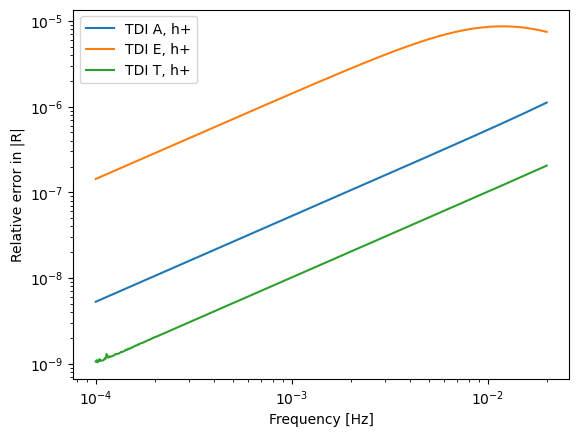

In [ ]:
for i in range(3):
    for j in range(1):
        plt.loglog(f, strain2x_angle_error[:, pix, i, j], label=f'TDI {'AET'[i]}, {pols[j]}')
        plt.xlabel("Frequency [Hz]")
        plt.ylabel("Relative error in |R|")
plt.legend()

In [ ]:
f[300]

np.float64(0.0024176017810051496)

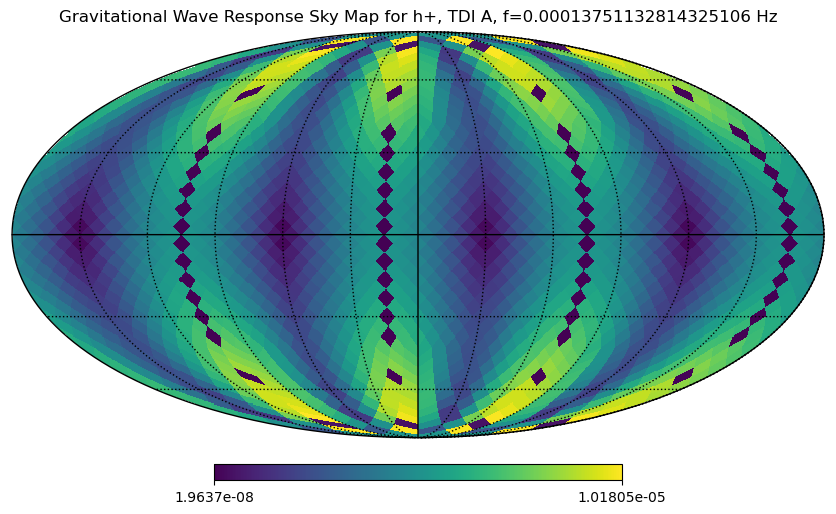

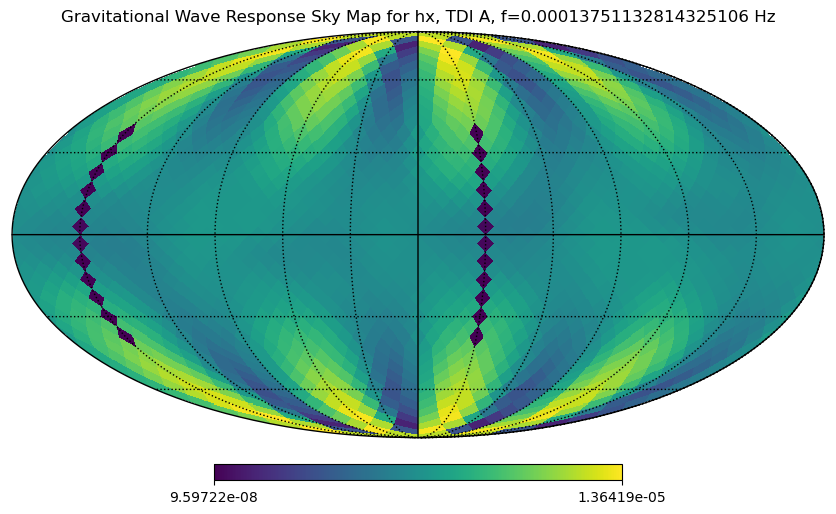

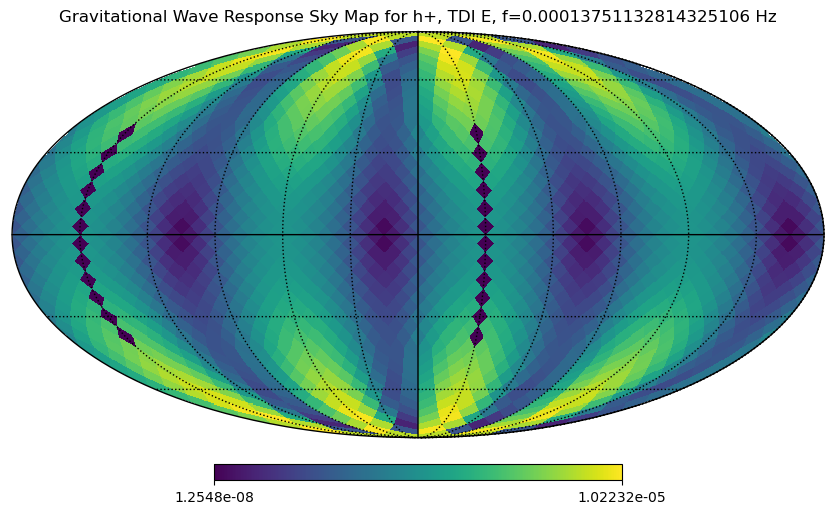

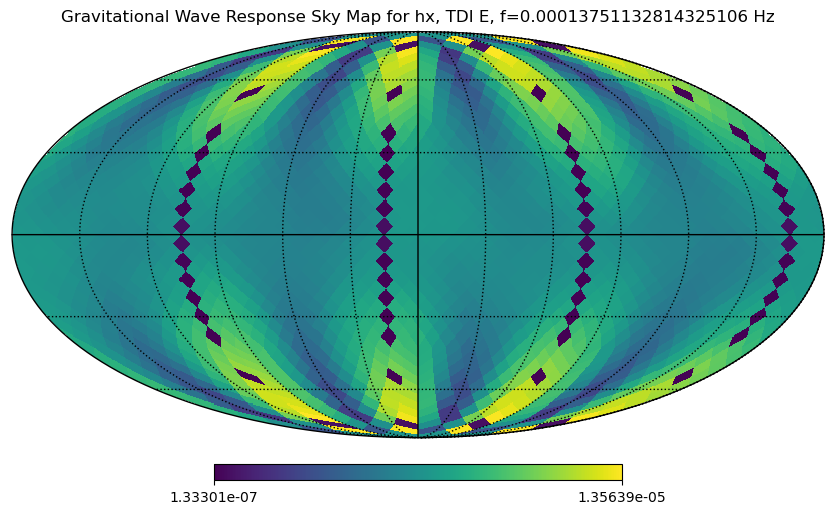

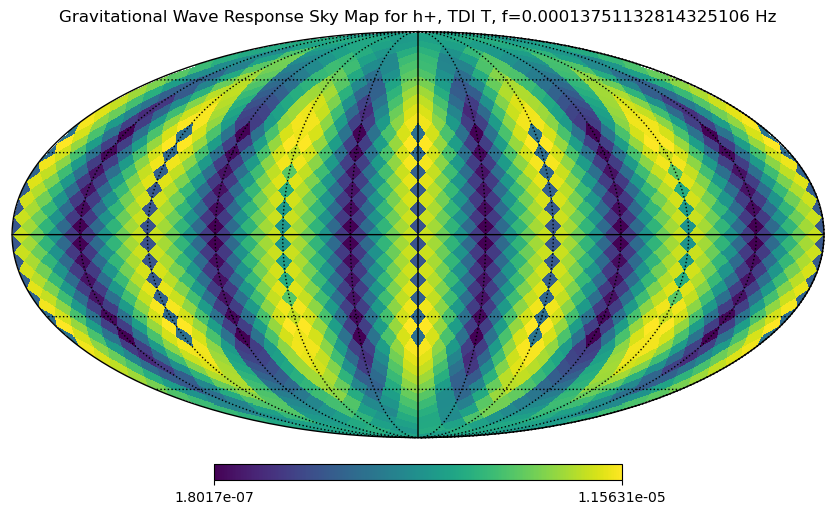

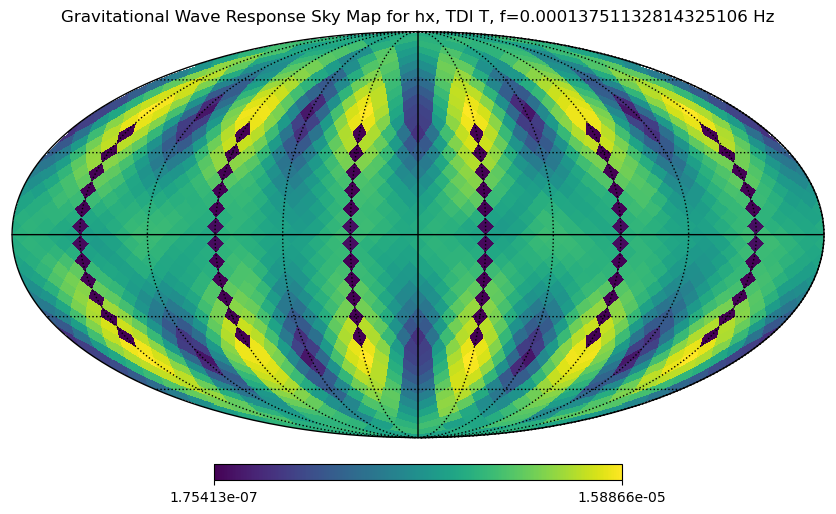

In [ ]:
# Placeholder for GW response map (this will be filled with your actual data)
gw_response_map = np.zeros(npix)


f_eval = 30 # frequency bin at which to evaluate the response
# pol = 0 # which polarization to use
pols = ['h+', 'hx']

for link in range(3):
    for pol in range(2):
        # link = 0 # which link to plot

        # Populate the map with the GW response for each pixel
        for pix in range(npix):
            # Compute the frequency-dependent GW response (replace with actual response)
            gw_response_map[pix] = strain2x_abs_error[f_eval, pix, link, pol]

        # Plotting the map
        hp.mollview(gw_response_map, title=f"Gravitational Wave Response Sky Map for {pols[pol]}, TDI {'AET'[link]}, f={f[f_eval]} Hz", rot=[0, 0])
        hp.graticule()
        plt.show()

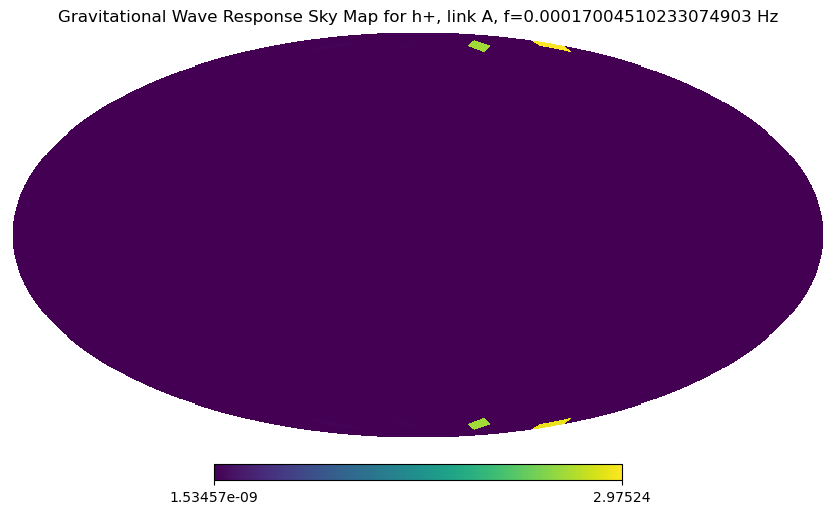

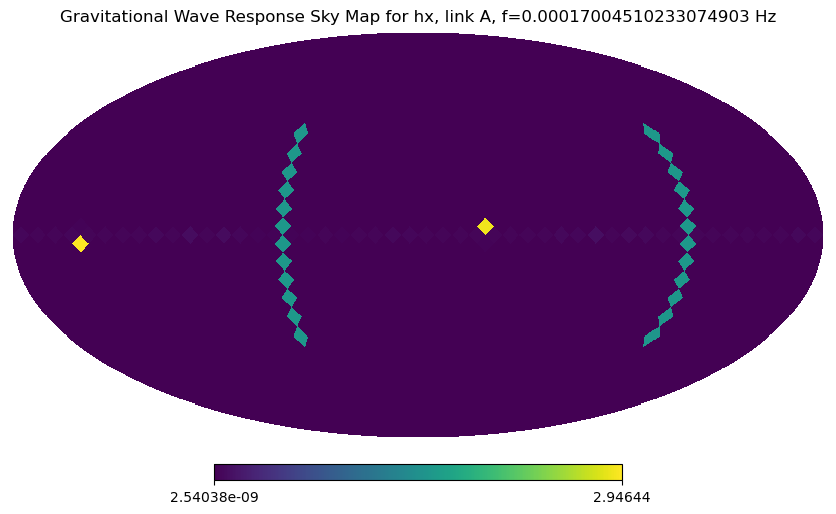

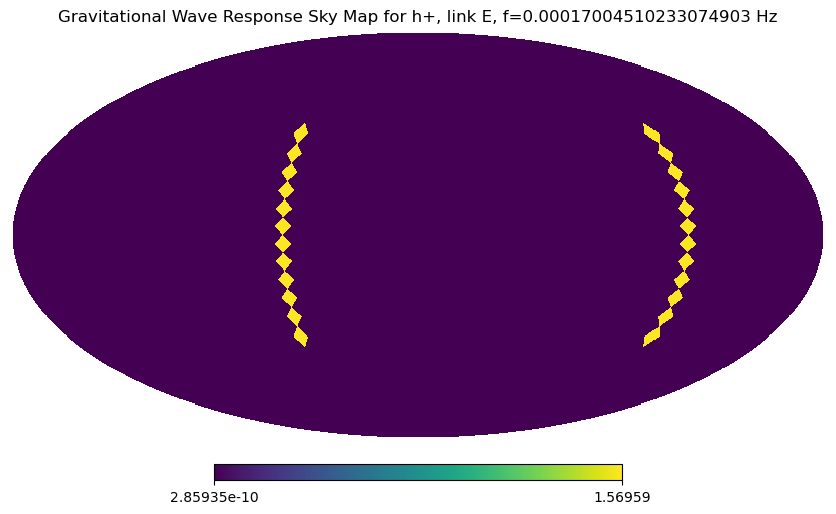

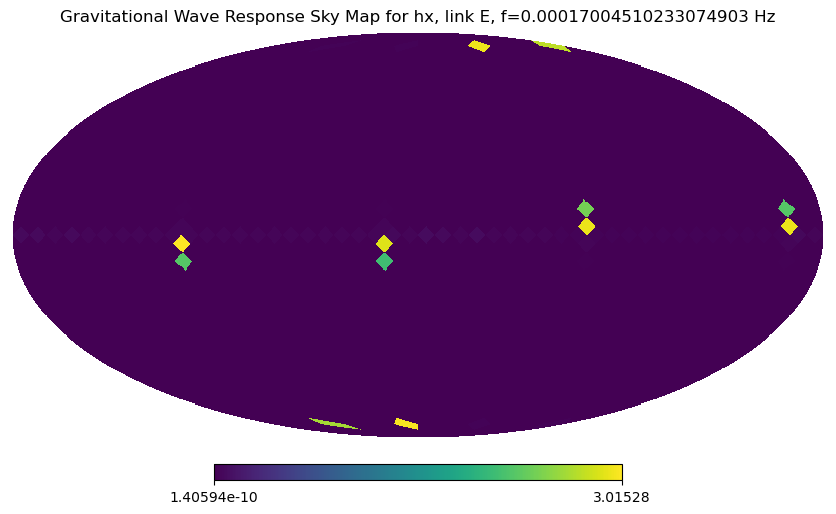

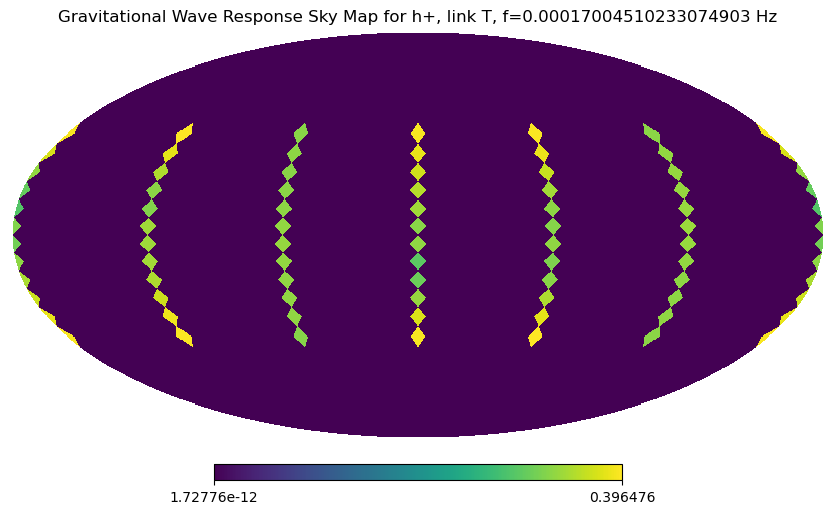

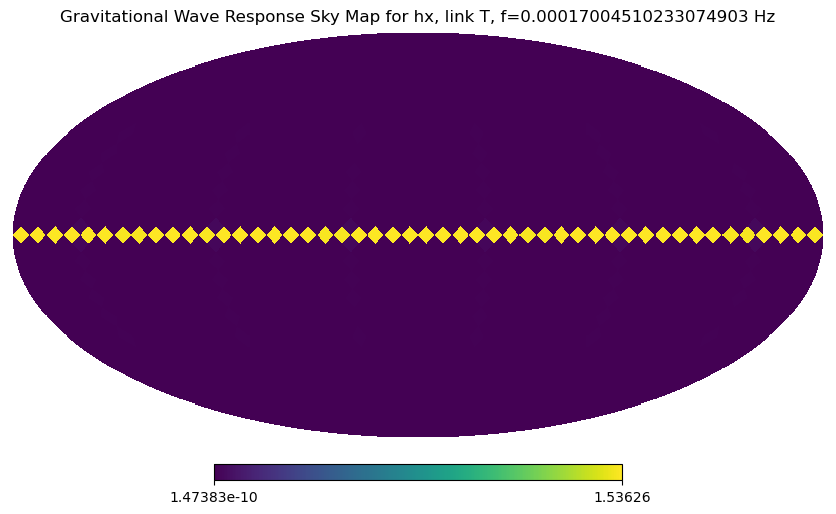

In [ ]:
# Placeholder for GW response map (this will be filled with your actual data)
gw_response_map = np.zeros(npix)


f_eval = 50 # frequency bin at which to evaluate the response
# pol = 0 # which polarization to use
pols = ['h+', 'hx']

for link in range(3):
    # link = 0 # which link to plot
    for pol in range(2):

        # Populate the map with the GW response for each pixel
        for pix in range(npix):
            # Compute the frequency-dependent GW response (replace with actual response)
            gw_response_map[pix] = strain2x_angle_error[f_eval, pix, link, pol]

        # Plotting the map
        hp.mollview(gw_response_map, title=f"Gravitational Wave Response Sky Map for {pols[pol]}, link {'AET'[link]}, f={f[f_eval]} Hz",)
        plt.show()

### Some statistics; over which range do we have violations?

In [ ]:
# Amplitude requirement: relative error of 1e-4
amp_req = 1e-4

In [ ]:
np.max(strain2x_abs_error)

np.float64(1.5887245908033603e-05)

In [ ]:
# for 50km: np.float64(0.00015752891239682187)

In [ ]:
# Data points which violate requirement
amp_violation_points = np.sum((strain2x_abs_error > amp_req))
amp_violation_points = np.sum((strain2x_abs_error > amp_req) & (strain2x != 0))
# Total data points
total_points = np.sum(strain2x_abs_error**0)
# Ratio of points that violate; it's half? That's pretty bad.
amp_violation_ratio = amp_violation_points / total_points
print(amp_violation_ratio)

0.0


In [ ]:
total_points

np.float64(5184000.0)

In [ ]:
# Phase requirement: relative error of 1e-2
phase_req = 1e-3

In [ ]:
strain2x.shape

(1, 500, 1728, 3, 2)

In [ ]:
np.max(strain2x_angle_error[strain2x[0] != 0])

np.float64(3.0690425608464533)

In [ ]:
# Data points which violate requirement
phase_violation_points = np.sum(strain2x_angle_error > phase_req)
# phase_violation_points = np.sum((strain2x_angle_error > phase_req) & (strain2x_abs_error > amp_req) & (strain2x != 0))
# Total data points
total_points = np.sum(strain2x_angle_error**0)
# Ratio of points that violate; it's half? That's pretty bad.
phase_violation_ratio = phase_violation_points / total_points
print(phase_violation_ratio)

0.036194637345679015


In [ ]:
strain2x.shape

(1, 500, 1728, 3, 2)

In [61]:
strain2x_angle_error[(strain2x_angle_error > phase_req) & (strain2x[0] != 0)]

array([0.039294  , 0.04092344, 0.03941004, ..., 1.35479959, 1.55253304,
       1.3975446 ], shape=(115567,))

## translations

In [62]:
# Generate some realizations so we can do statistics
N = 100
perturbed_ltt = np.zeros((N, 6))
perturbed_positions = np.zeros((N, 3, 3))

for i in range(N):
    perturbed_orbit = perturbed_static_orbits(
        arm_lengths=[2.5e9, 2.5e9, 2.5e9], 
        armlength_error=0, 
        rotation_error=0, 
        translation_error=50e3
    )

    perturbed_ltt[i] = perturbed_orbit.compute_ltt(t=[0.0])
    perturbed_positions[i] = perturbed_orbit.compute_position(t=[0.0])

In [63]:
# Compute the signal covariance matrix for eta variables

# We use healpy to define a grid of points on the sky
nside = 12
npix = hp.nside2npix(nside)
thetas, phis = hp.pix2ang(nside, np.arange(npix))
# Conversion from colatitude to latitude
betas, lambs = np.pi / 2 - thetas, phis

# this uses a bit of memory, and takes a moment; around 30s and 30GB on my machine
strain2links_perturbed = segwo.response.compute_strain2link(
                f, betas, lambs, perturbed_ltt, perturbed_positions # we're hi-jacking the time argument of segwo here for our realizations
            )

link2x_perturbed = segwo.cov.construct_mixing_from_pytdi(f, eta_list, [A, E, T], ltts)

# We need to manually fill in the array for each pixel
link2x_perturbed = link2x_perturbed[:,:,np.newaxis,:,:]

# We can then compose the mixing matrices to go directly from strain to TDI variables
strain2x_perturbed = segwo.cov.compose_mixings([strain2links_perturbed, link2x_perturbed])

In [64]:
strain2x_perturbed.shape

(100, 500, 1728, 3, 2)

In [65]:
def relative_errors(a, b):
    """ Compute the relative errors between two arrays
    """
    return np.abs(a - b) / np.abs(b)

def relative_errors_sky(a, b):
    """ Compute the relative errors between two arrays, 
        wrt. the direction of maximum amplitude
    """
    return np.abs(a - b) / np.max(np.abs(b), axis=2)[:, :, np.newaxis, :, :]

In [66]:
def absolute_errors(a, b):
    """ Compute the relative errors between two arrays
    """
    return np.abs(a - b)

In [67]:
# Compute std for amplitude of perturbed response
strain2x_abs_error = np.std(relative_errors_sky(np.abs(strain2x_perturbed), np.abs(strain2x)), axis=0)

In [68]:
strain2x_abs_error.shape

(500, 1728, 3, 2)

0.0 3.20704250053958


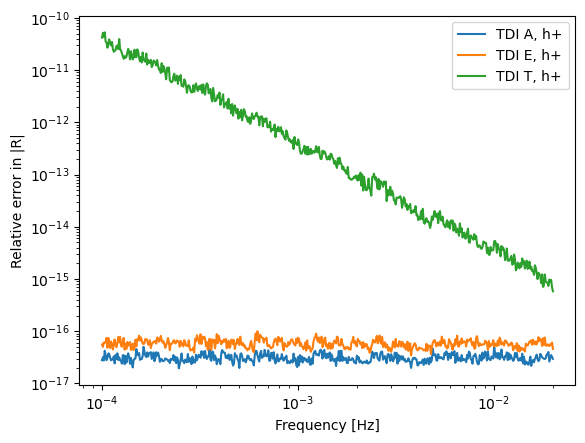

In [69]:
# Result heavily depends on pixel
pix = npix // 2
print(betas[pix], lambs[pix])

for i in range(3):
    for j in range(1):
        plt.loglog(f, strain2x_abs_error[:, pix, i, j], label=f'TDI {'AET'[i]}, {pols[j]}')
        plt.xlabel("Frequency [Hz]")
        plt.ylabel("Relative error in |R|")
plt.legend()

In [70]:
# Compute std for amplitude of perturbed response
strain2x_angle_error = np.std(absolute_errors(np.angle(strain2x_perturbed), np.angle(strain2x)), axis=0)

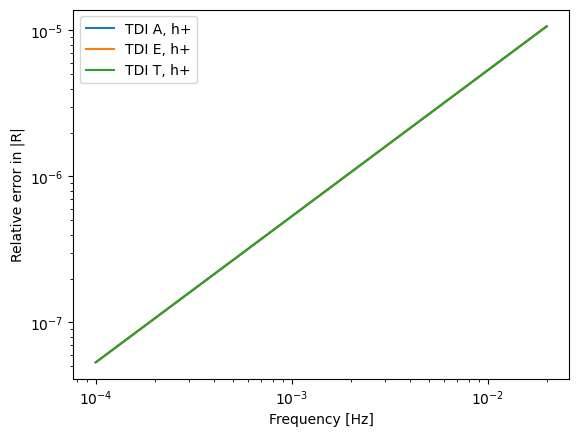

In [71]:
for i in range(3):
    for j in range(1):
        plt.loglog(f, strain2x_angle_error[:, pix, i, j], label=f'TDI {'AET'[i]}, {pols[j]}')
        plt.xlabel("Frequency [Hz]")
        plt.ylabel("Relative error in |R|")
plt.legend()

In [72]:
f[300]

np.float64(0.0024176017810051496)

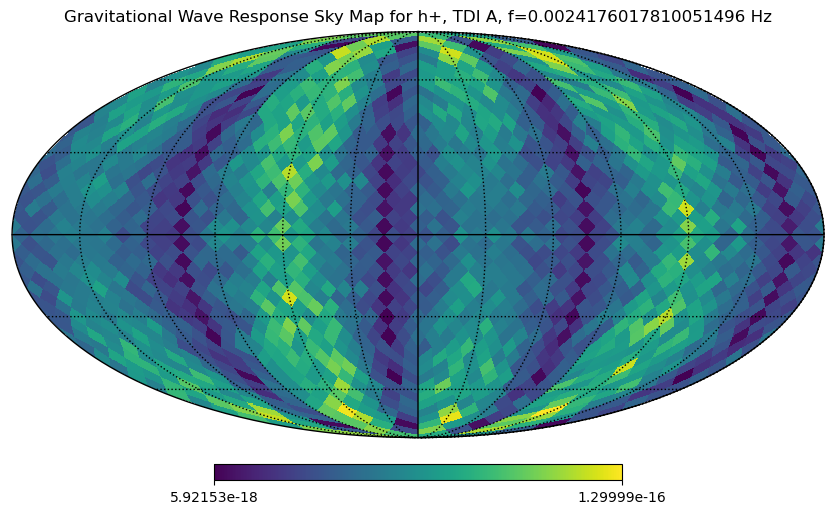

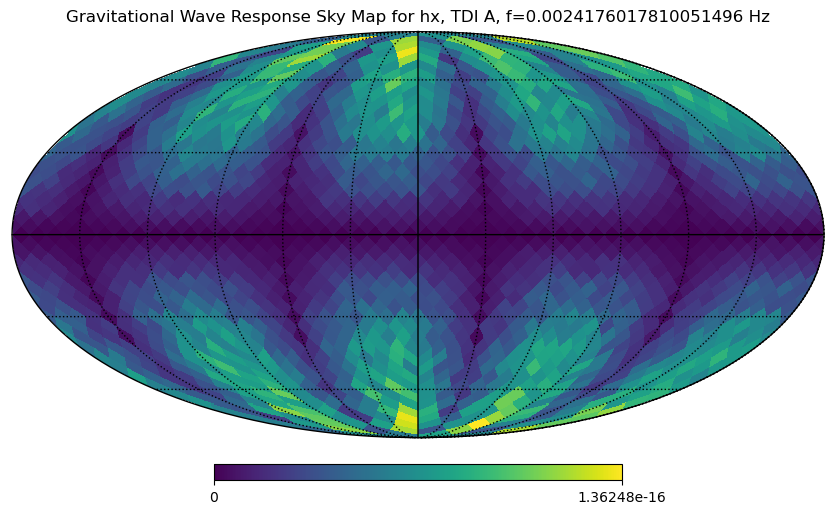

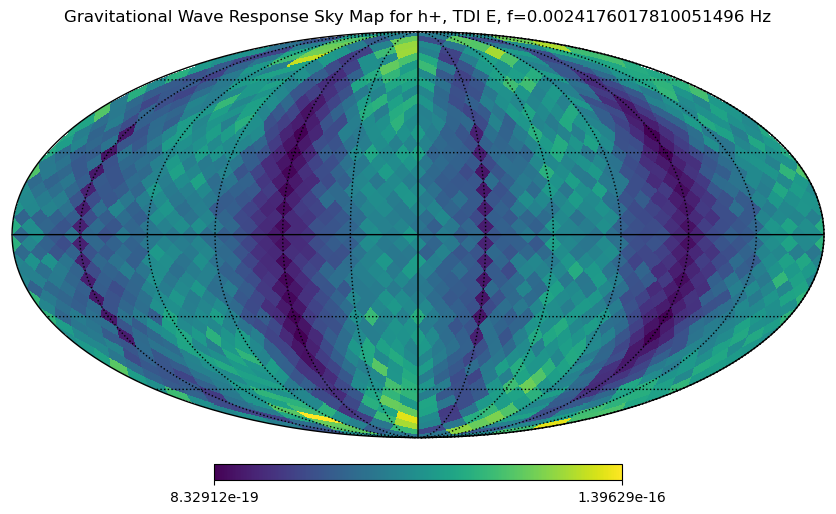

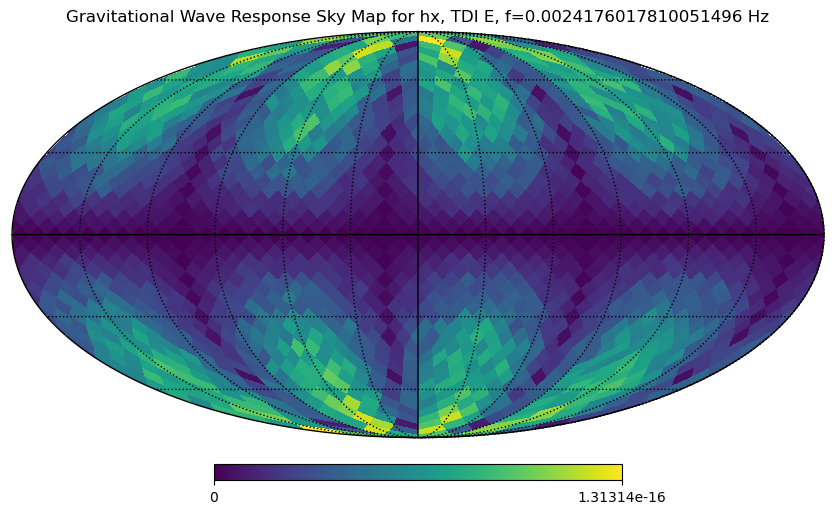

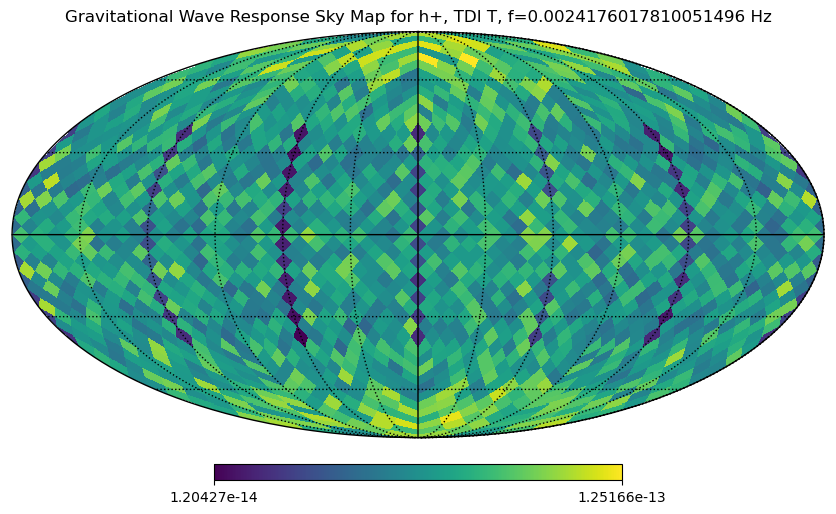

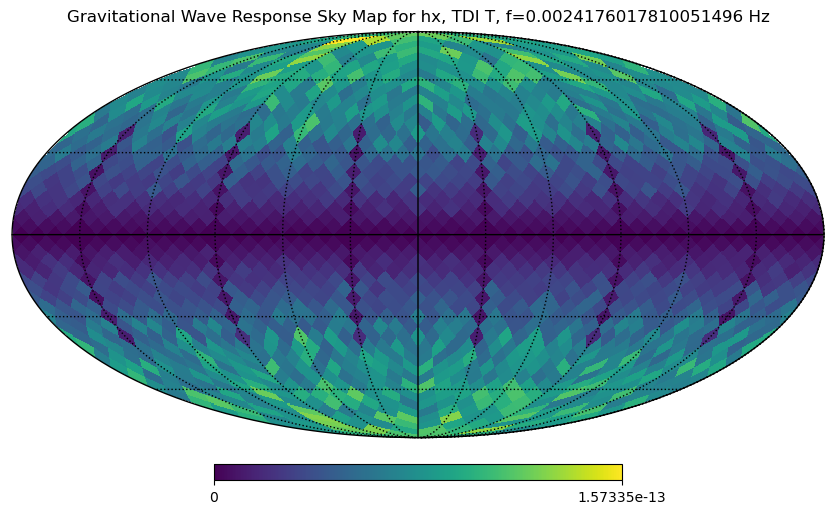

In [73]:
# Placeholder for GW response map (this will be filled with your actual data)
gw_response_map = np.zeros(npix)


f_eval = 300 # frequency bin at which to evaluate the response
# pol = 0 # which polarization to use
pols = ['h+', 'hx']

for link in range(3):
    for pol in range(2):
        # link = 0 # which link to plot

        # Populate the map with the GW response for each pixel
        for pix in range(npix):
            # Compute the frequency-dependent GW response (replace with actual response)
            gw_response_map[pix] = strain2x_abs_error[f_eval, pix, link, pol]

        # Plotting the map
        hp.mollview(gw_response_map, title=f"Gravitational Wave Response Sky Map for {pols[pol]}, TDI {'AET'[link]}, f={f[f_eval]} Hz", rot=[0, 0])
        hp.graticule()
        plt.show()

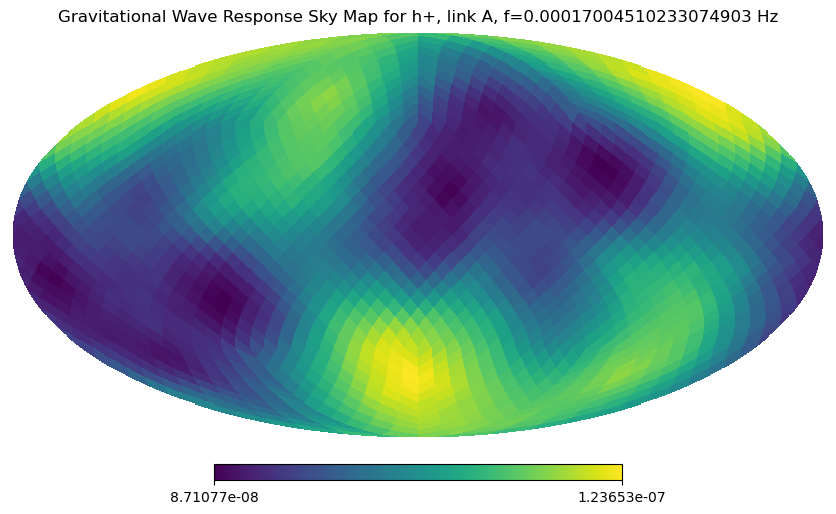

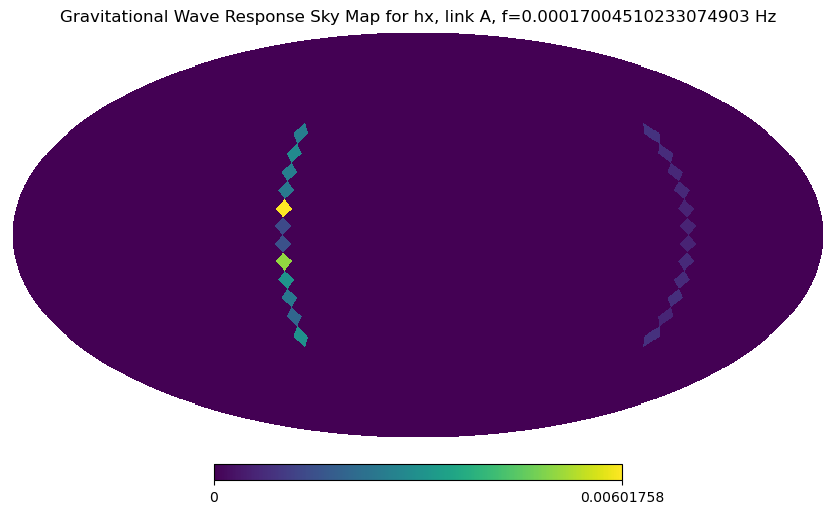

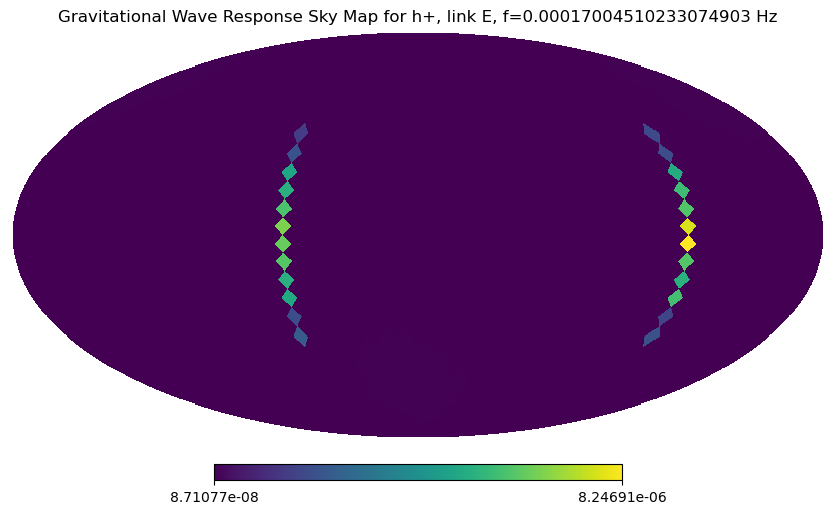

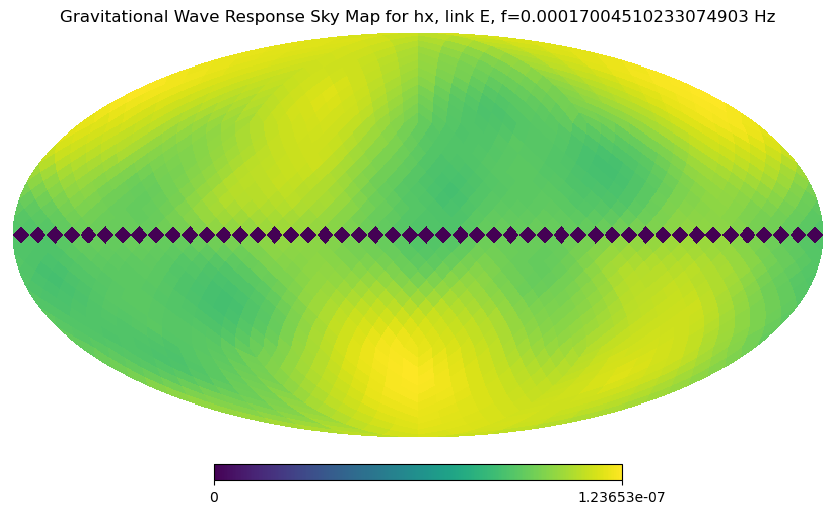

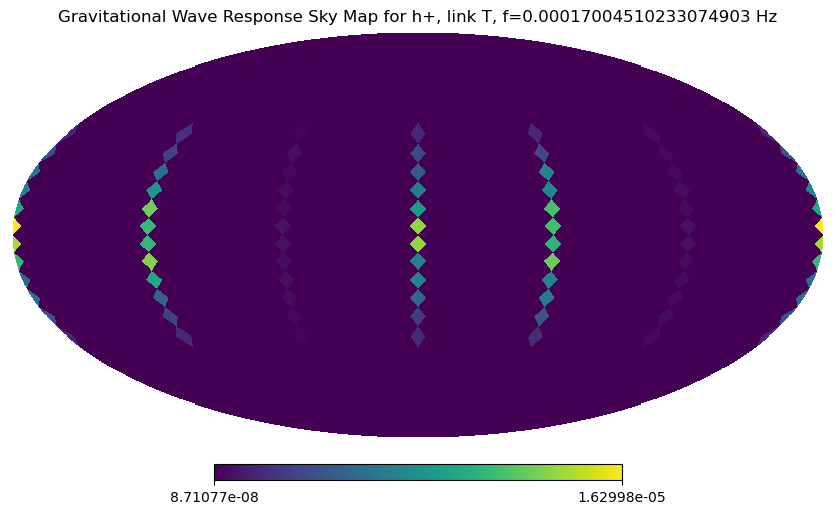

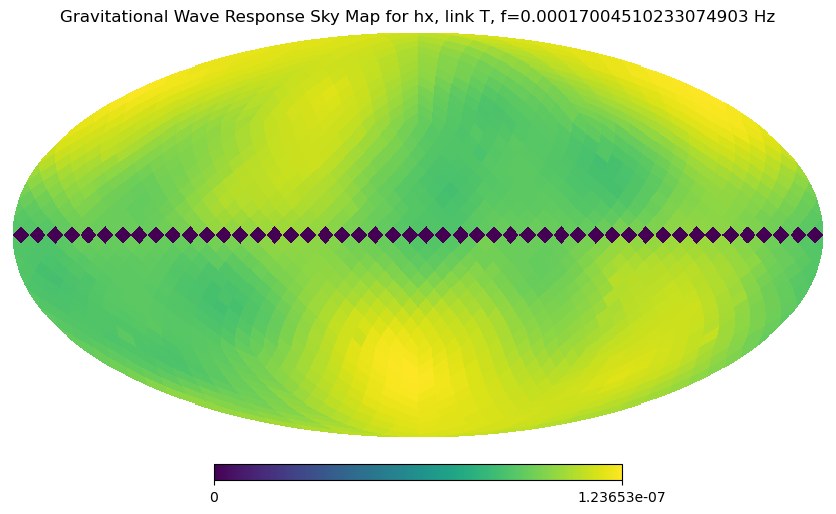

In [74]:
# Placeholder for GW response map (this will be filled with your actual data)
gw_response_map = np.zeros(npix)


f_eval = 50 # frequency bin at which to evaluate the response
# pol = 0 # which polarization to use
pols = ['h+', 'hx']

for link in range(3):
    # link = 0 # which link to plot
    for pol in range(2):

        # Populate the map with the GW response for each pixel
        for pix in range(npix):
            # Compute the frequency-dependent GW response (replace with actual response)
            gw_response_map[pix] = strain2x_angle_error[f_eval, pix, link, pol]

        # Plotting the map
        hp.mollview(gw_response_map, title=f"Gravitational Wave Response Sky Map for {pols[pol]}, link {'AET'[link]}, f={f[f_eval]} Hz",)
        plt.show()

### Some statistics; over which range do we have violations?

In [75]:
# Amplitude requirement: relative error of 1e-4
amp_req = 1e-4

In [76]:
# Data points which violate requirement
amp_violation_points = np.sum(strain2x_abs_error > amp_req)
# Total data points
total_points = np.sum(strain2x_abs_error**0)
# Ratio of points that violate; it's half? That's pretty bad.
amp_violation_ratio = amp_violation_points / total_points
print(amp_violation_ratio)

0.0


In [77]:
# Phase requirement: relative error of 1e-2
phase_req = 1e-2

In [78]:
# Data points which violate requirement
phase_violation_points = np.sum(strain2x_angle_error > phase_req)
# Total data points
total_points = np.sum(strain2x_angle_error**0)
# Ratio of points that violate; it's half? That's pretty bad.
phase_violation_ratio = phase_violation_points / total_points
print(phase_violation_ratio)

0.00393653549382716


## armlength

In [79]:
# Generate some realizations so we can do statistics
N = 100
perturbed_ltt = np.zeros((N, 6))
perturbed_positions = np.zeros((N, 3, 3))

for i in range(N):
    perturbed_orbit = perturbed_static_orbits(
        arm_lengths=[2.5e9, 2.5e9, 2.5e9], 
        armlength_error=1, 
        rotation_error=0, 
        translation_error=0
    )

    perturbed_ltt[i] = perturbed_orbit.compute_ltt(t=[0.0])
    perturbed_positions[i] = perturbed_orbit.compute_position(t=[0.0])

In [80]:
# Compute the signal covariance matrix for eta variables

# We use healpy to define a grid of points on the sky
nside = 12
npix = hp.nside2npix(nside)
thetas, phis = hp.pix2ang(nside, np.arange(npix))
# Conversion from colatitude to latitude
betas, lambs = np.pi / 2 - thetas, phis

# this uses a bit of memory, and takes a moment; around 30s and 30GB on my machine
strain2links_perturbed = segwo.response.compute_strain2link(
                f, betas, lambs, perturbed_ltt, perturbed_positions # we're hi-jacking the time argument of segwo here for our realizations
            )

link2x_perturbed = segwo.cov.construct_mixing_from_pytdi(f, eta_list, [A, E, T], ltts)

# We need to manually fill in the array for each pixel
link2x_perturbed = link2x_perturbed[:,:,np.newaxis,:,:]

# We can then compose the mixing matrices to go directly from strain to TDI variables
strain2x_perturbed = segwo.cov.compose_mixings([strain2links_perturbed, link2x_perturbed])

In [81]:
strain2x_perturbed.shape

(100, 500, 1728, 3, 2)

In [82]:
def relative_errors(a, b):
    """ Compute the relative errors between two arrays
    """
    return np.abs(a - b) / np.abs(b)

def relative_errors_sky(a, b):
    """ Compute the relative errors between two arrays, 
        wrt. the direction of maximum amplitude
    """
    return np.abs(a - b) / np.max(np.abs(b), axis=2)[:, :, np.newaxis, :, :]

In [83]:
def absolute_errors(a, b):
    """ Compute the relative errors between two arrays
    """
    return np.abs(a - b)

In [84]:
# Compute std for amplitude of perturbed response
strain2x_abs_error = np.std(relative_errors_sky(np.abs(strain2x_perturbed), np.abs(strain2x)), axis=0)

In [85]:
strain2x_abs_error.shape

(500, 1728, 3, 2)

0.0 3.20704250053958


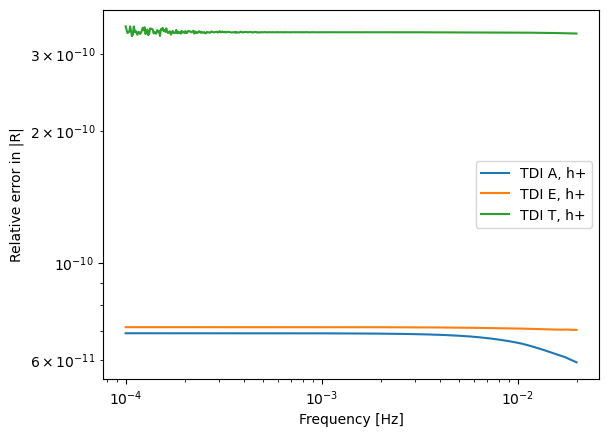

In [86]:
# Result heavily depends on pixel
pix = npix // 2
print(betas[pix], lambs[pix])

for i in range(3):
    for j in range(1):
        plt.loglog(f, strain2x_abs_error[:, pix, i, j], label=f'TDI {'AET'[i]}, {pols[j]}')
        plt.xlabel("Frequency [Hz]")
        plt.ylabel("Relative error in |R|")
plt.legend()

In [87]:
# Compute std for amplitude of perturbed response
strain2x_angle_error = np.std(absolute_errors(np.angle(strain2x_perturbed), np.angle(strain2x)), axis=0)

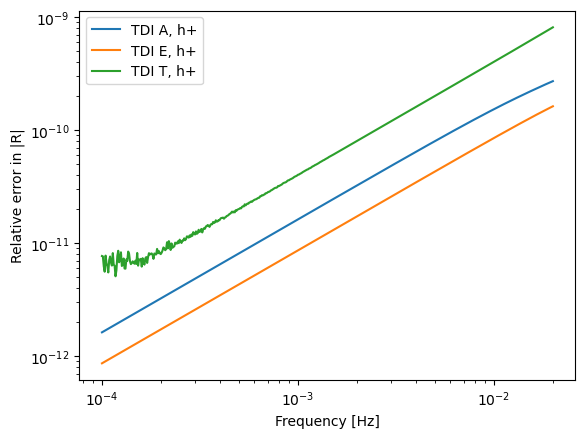

In [88]:
for i in range(3):
    for j in range(1):
        plt.loglog(f, strain2x_angle_error[:, pix, i, j], label=f'TDI {'AET'[i]}, {pols[j]}')
        plt.xlabel("Frequency [Hz]")
        plt.ylabel("Relative error in |R|")
plt.legend()

In [89]:
f[300]

np.float64(0.0024176017810051496)

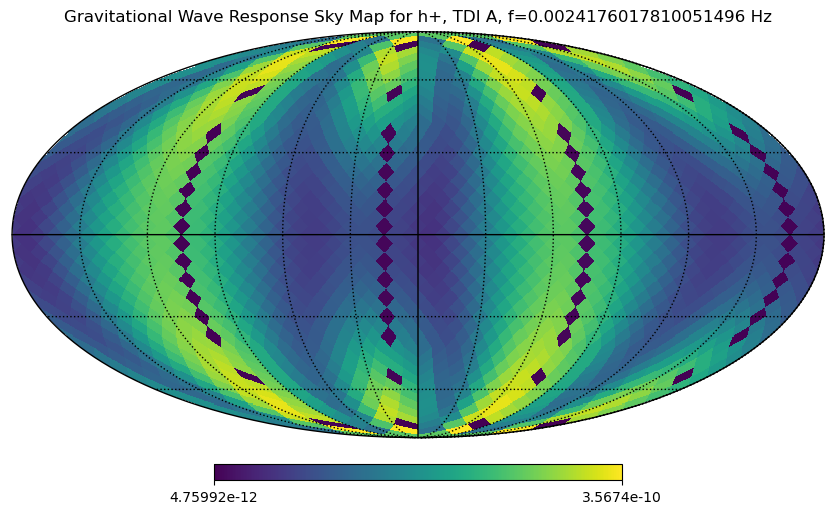

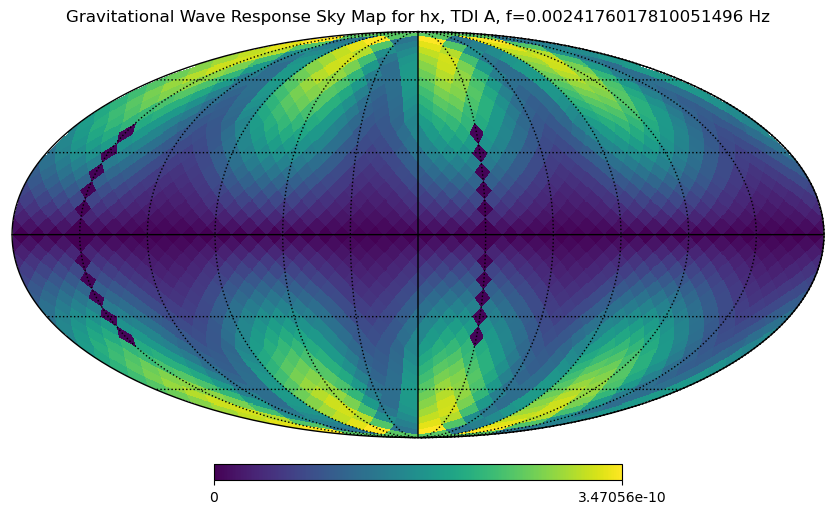

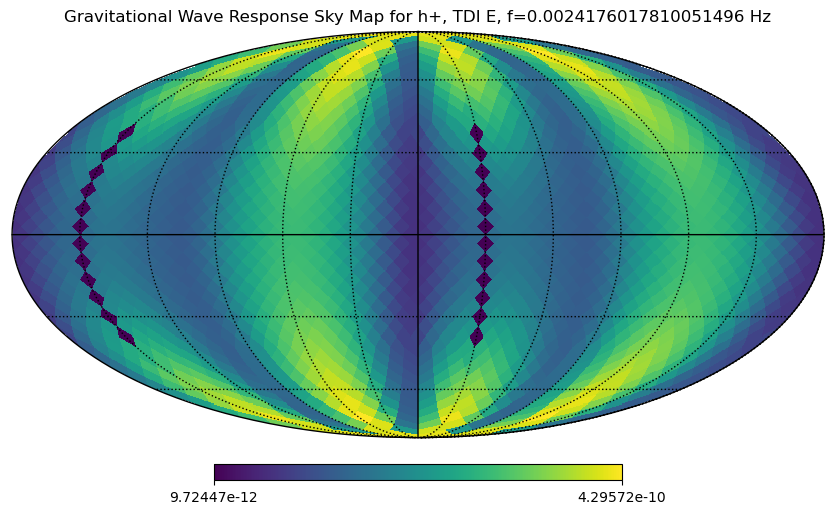

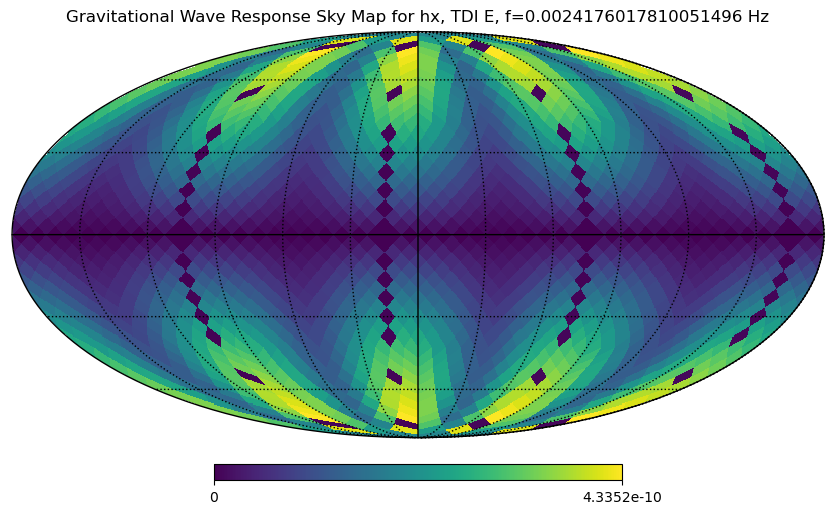

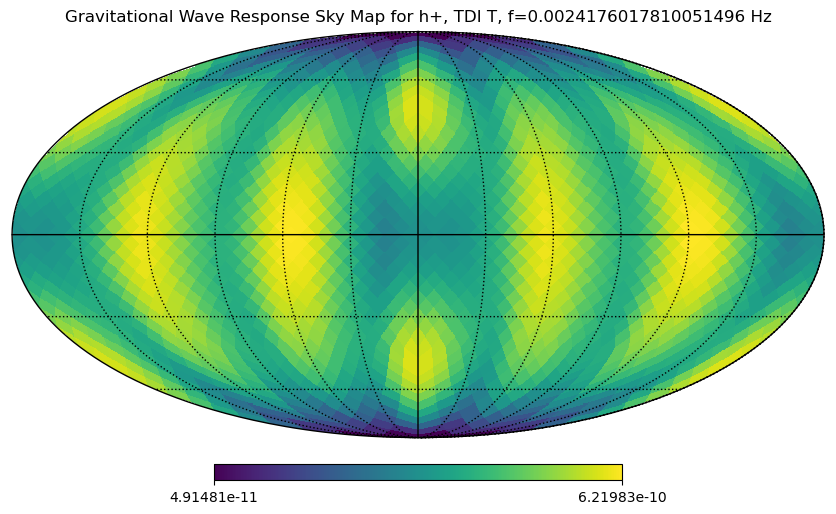

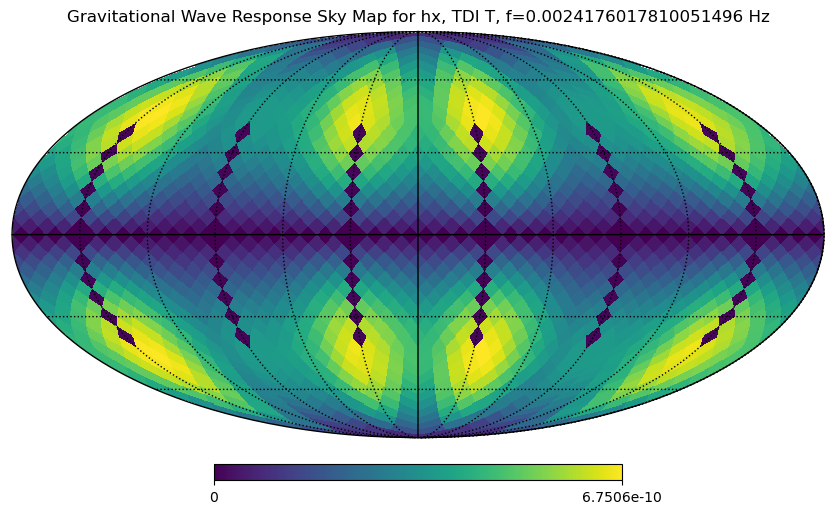

In [90]:
# Placeholder for GW response map (this will be filled with your actual data)
gw_response_map = np.zeros(npix)


f_eval = 300 # frequency bin at which to evaluate the response
# pol = 0 # which polarization to use
pols = ['h+', 'hx']

for link in range(3):
    for pol in range(2):
        # link = 0 # which link to plot

        # Populate the map with the GW response for each pixel
        for pix in range(npix):
            # Compute the frequency-dependent GW response (replace with actual response)
            gw_response_map[pix] = strain2x_abs_error[f_eval, pix, link, pol]

        # Plotting the map
        hp.mollview(gw_response_map, title=f"Gravitational Wave Response Sky Map for {pols[pol]}, TDI {'AET'[link]}, f={f[f_eval]} Hz", rot=[0, 0])
        hp.graticule()
        plt.show()

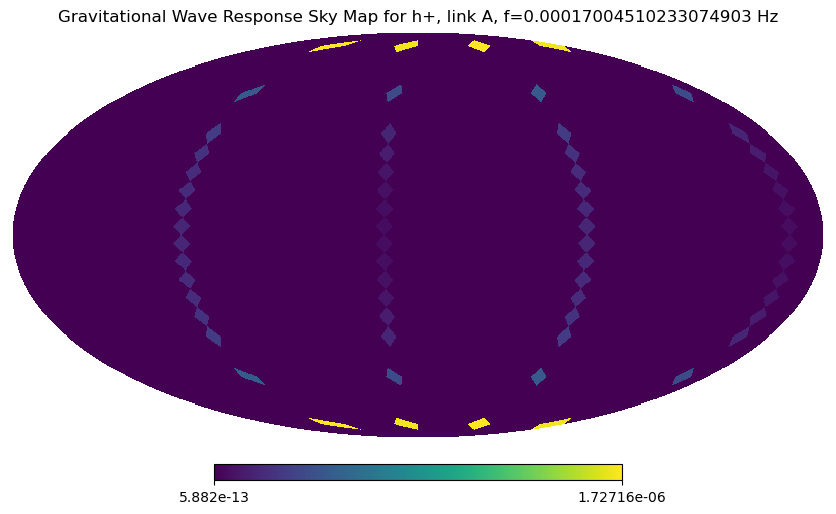

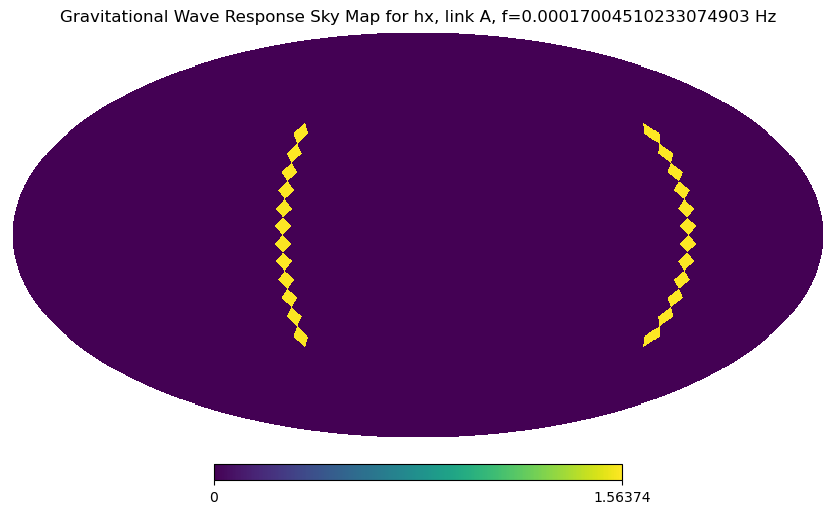

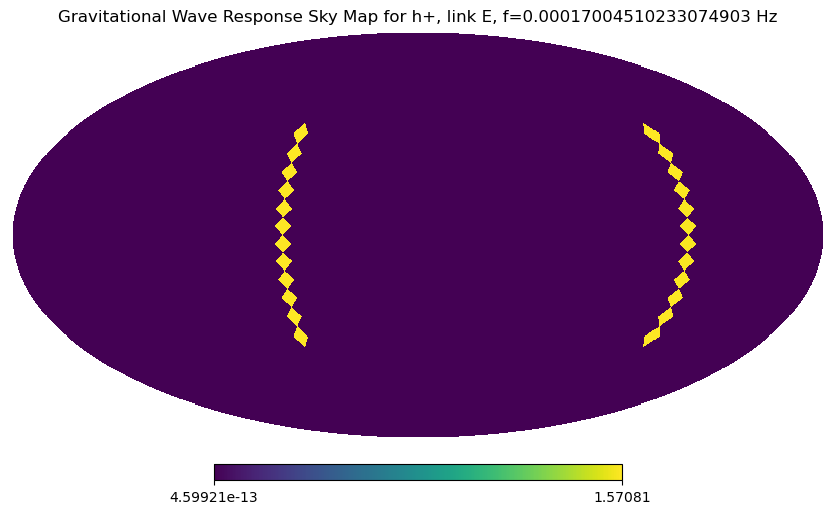

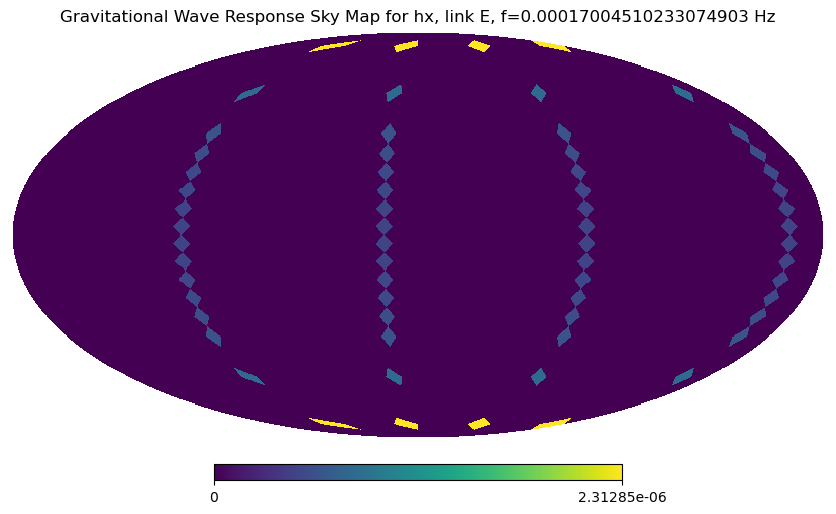

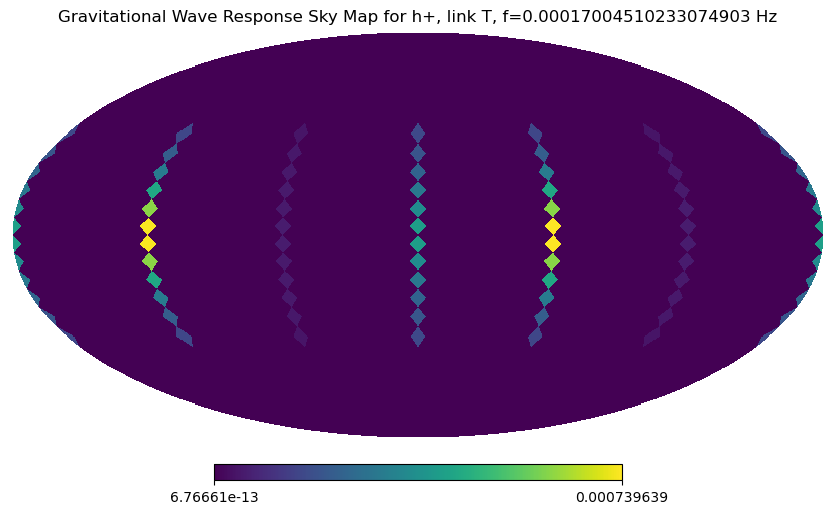

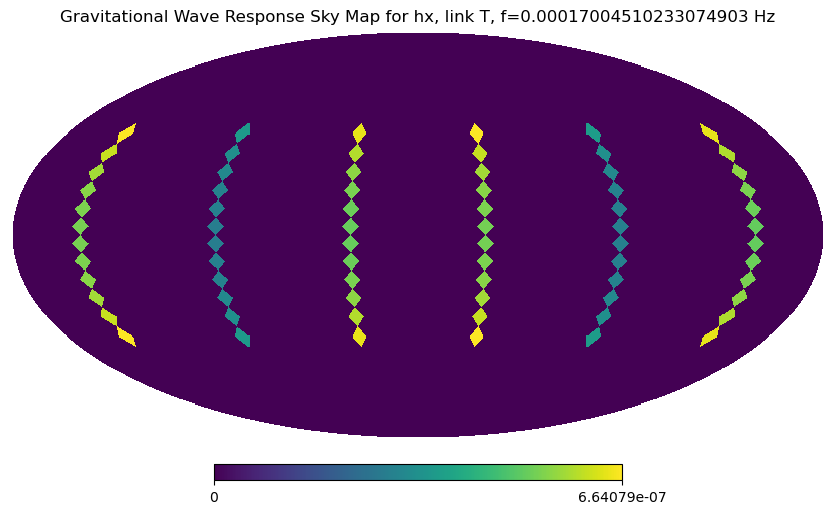

In [91]:
# Placeholder for GW response map (this will be filled with your actual data)
gw_response_map = np.zeros(npix)


f_eval = 50 # frequency bin at which to evaluate the response
# pol = 0 # which polarization to use
pols = ['h+', 'hx']

for link in range(3):
    # link = 0 # which link to plot
    for pol in range(2):

        # Populate the map with the GW response for each pixel
        for pix in range(npix):
            # Compute the frequency-dependent GW response (replace with actual response)
            gw_response_map[pix] = strain2x_angle_error[f_eval, pix, link, pol]

        # Plotting the map
        hp.mollview(gw_response_map, title=f"Gravitational Wave Response Sky Map for {pols[pol]}, link {'AET'[link]}, f={f[f_eval]} Hz",)
        plt.show()

### Some statistics; over which range do we have violations?

In [92]:
# Amplitude requirement: relative error of 1e-4
amp_req = 1e-4

In [93]:
# Data points which violate requirement
amp_violation_points = np.sum(strain2x_abs_error > amp_req)
# Total data points
total_points = np.sum(strain2x_abs_error**0)
# Ratio of points that violate; it's half? That's pretty bad.
amp_violation_ratio = amp_violation_points / total_points
print(amp_violation_ratio)

0.0


In [94]:
# Phase requirement: relative error of 1e-2
phase_req = 1e-2

In [95]:
# Data points which violate requirement
phase_violation_points = np.sum(strain2x_angle_error > phase_req)
# Total data points
total_points = np.sum(strain2x_angle_error**0)
# Ratio of points that violate; it's half? That's pretty bad.
phase_violation_ratio = phase_violation_points / total_points
print(phase_violation_ratio)

0.00967380401234568
